## Followed this notebook: https://github.com/EmuKit/emukit/blob/main/notebooks/Emukit-tutorial-multi-fidelity.ipynb

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import importlib.util
import random
random.seed(42)

import GPy
from emukit.multi_fidelity.kernels import LinearMultiFidelityKernel
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

In [2]:
with open("../coherent/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp  = config_file["path_settings"]["path_out_cnp"]
path_out_mfgp = config_file["path_settings"]["path_out_mfgp"]
file_in=f'{path_out_cnp}/cnp_{version}_output.csv'

In [3]:
# data processing/setup
np.random.seed(42)

if not os.path.exists(path_out_mfgp):
   os.makedirs(path_out_mfgp)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
y_label_cnp     = 'y_cnp'
y_err_label_cnp = 'y_cnp_err'
y_label_sim     = 'y_raw'

In [16]:
data=pd.read_csv(file_in)

LF_cnp_noise=np.mean(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
HF_cnp_noise=np.mean(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
LF_sim_noise=np.std(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_sim].to_numpy())
HF_sim_noise=np.std(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy())

# Get the filtered dataframe first
filtered_data = data.loc[(data['fidelity']==1.) & (data['iteration']==0)]

# # Get unique combinations of x_label values to select diverse training points
# unique_x_combinations = filtered_data[x_labels].drop_duplicates()

# # Select up to 3 diverse training points based on different x_label combinations
# if len(unique_x_combinations) >= 3:
#     # Select 3 points with most diverse x values
#     # Get min, max, and a middle point for each x dimension
#     x_data = unique_x_combinations.values
    
#     # Find points with min/max values for first dimension (water_shielding_mm)
#     min_x1_idx = np.argmin(x_data[:, 0])
#     max_x1_idx = np.argmax(x_data[:, 0])
    
#     # Find a point with different x2 value (veto_thickness_mm) that's not min/max x1
#     remaining_indices = [i for i in range(len(x_data)) if i not in [min_x1_idx, max_x1_idx]]
#     if remaining_indices:
#         # Select point with most different x2 value from the min/max x1 points
#         x1_values = x_data[[min_x1_idx, max_x1_idx], 1]
#         mid_x2_idx = remaining_indices[np.argmax([abs(x_data[i, 1] - np.mean(x1_values)) for i in remaining_indices])]
#     else:
#         mid_x2_idx = min_x1_idx if min_x1_idx != max_x1_idx else 0
    
#     selected_combinations = unique_x_combinations.iloc[[min_x1_idx, max_x1_idx, mid_x2_idx]]
# else:
#     # If fewer than 3 unique combinations, use all available
#     selected_combinations = unique_x_combinations

# # Find the indices in filtered_data that match these selected combinations
# train_indices = []
# for _, combo in selected_combinations.iterrows():
#     # Find first occurrence of this combination in filtered_data
#     mask = (filtered_data[x_labels[0]] == combo[x_labels[0]]) & (filtered_data[x_labels[1]] == combo[x_labels[1]])
#     matching_indices = filtered_data[mask].index.tolist()
#     if matching_indices:
#         train_indices.append(matching_indices[0])  # Take first occurrence

# test_indices = filtered_data.index.difference(train_indices)



# filtered_data = data.loc[(data['fidelity']==1.) & (data['iteration']==0)]

# unique_x_combinations = filtered_data[x_labels].drop_duplicates().values

# combination_1 = []
# combination_2 = []
# combination_3 = []

# samples_with_combination_1 = filtered_data.loc[filtered_data[x_labels].values==unique_x_combinations[0]]
# combination_1.extend(list(set(samples_with_combination_1.index.to_list())))
# samples_with_combination_2 = filtered_data.loc[filtered_data[x_labels].values==unique_x_combinations[1]]
# combination_2.extend(list(set(samples_with_combination_2.index.to_list())))
# samples_with_combination_3 = filtered_data.loc[filtered_data[x_labels].values==unique_x_combinations[2]]
# combination_3.extend(list(set(samples_with_combination_3.index.to_list())))

# random.shuffle(combination_1)
# random.shuffle(combination_2)
# random.shuffle(combination_3)

# combination_1_70 = combination_1[:int(len(combination_1) // (10/9))]
# combination_1_30 = combination_1[int(len(combination_1) // (10/9)):]
# combination_2_70 = combination_2[:int(len(combination_2) // (10/9))]
# combination_2_30 = combination_2[int(len(combination_2) // (10/9)):]
# combination_3_70 = combination_3[:int(len(combination_3) // (10/9))]
# combination_3_30 = combination_3[int(len(combination_3) // (10/9)):]


# # Extract training data
# x_train_hf_sim = filtered_data.loc[train_indices][x_labels].to_numpy().tolist()
# y_train_hf_sim = filtered_data.loc[train_indices][y_label_sim].to_numpy().tolist()

# # Extract testing data
# x_test_hf_sim = filtered_data.loc[test_indices][x_labels].to_numpy().tolist()
# y_test_hf_sim = filtered_data.loc[test_indices][y_label_sim].to_numpy().tolist()

# Approach 2
# Extract training data
x_train_hf_sim = filtered_data[x_labels].to_numpy().tolist()
y_train_hf_sim = filtered_data[y_label_sim].to_numpy().tolist()

# # Extract testing data
# x_test_hf_sim = filtered_data[x_labels].to_numpy().tolist()
# y_test_hf_sim = filtered_data[y_label_sim].to_numpy().tolist()

# ## Approach 3
# # Extract training data
# x_train_hf_sim = filtered_data.loc[combination_1_70][x_labels].to_numpy().tolist()
# x_train_hf_sim.extend(filtered_data.loc[combination_2_70][x_labels].to_numpy().tolist())
# x_train_hf_sim.extend(filtered_data.loc[combination_3_70][x_labels].to_numpy().tolist())
# y_train_hf_sim = filtered_data.loc[combination_1_70][y_label_sim].to_numpy().tolist()
# y_train_hf_sim.extend(filtered_data.loc[combination_2_70][y_label_sim].to_numpy().tolist())
# y_train_hf_sim.extend(filtered_data.loc[combination_3_70][y_label_sim].to_numpy().tolist())
# combined_train_hf_sim = list(zip(x_train_hf_sim, y_train_hf_sim))
# random.shuffle(combined_train_hf_sim)
# x_train_hf_sim, y_train_hf_sim = zip(*combined_train_hf_sim)
# x_train_hf_sim = list(x_train_hf_sim)
# y_train_hf_sim = list(y_train_hf_sim)

# # Extract testing data
# x_test_hf_sim = filtered_data.loc[combination_1_30][x_labels].to_numpy().tolist()
# x_test_hf_sim.extend(filtered_data.loc[combination_2_30][x_labels].to_numpy().tolist())
# x_test_hf_sim.extend(filtered_data.loc[combination_3_30][x_labels].to_numpy().tolist())
# y_test_hf_sim = filtered_data.loc[combination_1_30][y_label_sim].to_numpy().tolist()
# y_test_hf_sim.extend(filtered_data.loc[combination_2_30][y_label_sim].to_numpy().tolist())
# y_test_hf_sim.extend(filtered_data.loc[combination_3_30][y_label_sim].to_numpy().tolist())
# combined_test_hf_sim = list(zip(x_test_hf_sim, y_test_hf_sim))
# random.shuffle(combined_test_hf_sim)
# x_test_hf_sim, y_test_hf_sim = zip(*combined_test_hf_sim)
# x_test_hf_sim = list(x_test_hf_sim)
# y_test_hf_sim = list(y_test_hf_sim)

x_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_cnp].to_numpy().tolist()


trainings_data = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}#, } "mf": [x_train_hf_cnp,y_train_hf_cnp]
noise = {"lf": LF_cnp_noise, "hf": HF_sim_noise*0.001}#, "hf": 0.0}  # why were mf and hf noise originally set to 0?
# noise = {"lf": 1.7e-6, "hf": 1.7e-6}

FileNotFoundError: [Errno 2] No such file or directory: '../coherent/out/cnp/cnp_v1.0_output.csv'

In [5]:
fidelities = list(trainings_data.keys())
nfidelities = len(fidelities)

In [6]:
x_train = []
y_train = []
for fidelity in fidelities:
    x_tmp=np.atleast_2d(trainings_data[fidelity][0])
    y_tmp=np.atleast_2d(trainings_data[fidelity][1]).T
    x_train.append(x_tmp)
    y_train.append(y_tmp)

X_train, Y_train = convert_xy_lists_to_arrays(x_train, y_train)

In [7]:
num_fidelities = 2  # just lf and hf for now
kernels = [GPy.kern.Matern32(input_dim=X_train[0].shape[0] - 1), GPy.kern.Matern32(input_dim=X_train[0].shape[0] - 1)]  # since there are two theta parameters, input_dim is 2
# kernels = [GPy.kern.RBF(input_dim=X_train[0].shape[0] - 1), GPy.kern.RBF(input_dim=X_train[0].shape[0] - 1)]

linear_mf_kernel = LinearMultiFidelityKernel(kernels)
gpy_linear_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, linear_mf_kernel, n_fidelities = num_fidelities)

# set noise
gpy_linear_mf_model.mixed_noise.Gaussian_noise.fix(noise['lf'])  # lf noise
gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.fix(noise['hf'])  # mf/hf noise

array([0])

In [8]:
# SET KERNEL HYPERPARAMETER BOUNDS
# Low-fidelity kernel (Mat32)
gpy_linear_mf_model['multifidelity.Mat32.variance'].constrain_bounded(1e-6, 1e2)
gpy_linear_mf_model['multifidelity.Mat32.lengthscale'].constrain_bounded(1e-2, 1e3)

# High-fidelity kernel (Mat32_1) 
gpy_linear_mf_model['multifidelity.Mat32_1.variance'].constrain_bounded(1e-6, 1e2)
gpy_linear_mf_model['multifidelity.Mat32_1.lengthscale'].constrain_bounded(1e-2, 1e3)

# # Low-fidelity kernel (RBF)
# gpy_linear_mf_model['multifidelity.rbf.variance'].constrain_bounded(1e-6, 1e2)
# gpy_linear_mf_model['multifidelity.rbf.lengthscale'].constrain_bounded(1e-2, 1e3)

# # High-fidelity kernel (RBF_1) 
# gpy_linear_mf_model['multifidelity.rbf_1.variance'].constrain_bounded(1e-6, 1e2)
# gpy_linear_mf_model['multifidelity.rbf_1.lengthscale'].constrain_bounded(1e-2, 1e3)

# Scale parameter (correlation between fidelities)
gpy_linear_mf_model['multifidelity.scale'].constrain_bounded(1e-3, 1e1)

# If you can unfix noise, increase it slightly
if hasattr(gpy_linear_mf_model.mixed_noise.Gaussian_noise, 'unfix'):
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.unfix()
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.unfix()
    
    # Set to 1.2x your original noise values with some bounds
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.constrain_bounded(
        noise['lf'] * 0.99, noise['lf'] * 1.01)
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.constrain_bounded(
        noise['hf'] * 0.99, noise['hf'] * 1.01)

reconstraining parameters gp.multifidelity.Mat32.variance
reconstraining parameters gp.multifidelity.Mat32.lengthscale
reconstraining parameters gp.multifidelity.Mat32_1.variance
reconstraining parameters gp.multifidelity.Mat32_1.lengthscale
reconstraining parameters gp.mixed_noise.Gaussian_noise
reconstraining parameters gp.mixed_noise.Gaussian_noise_1


In [9]:
'''# More aggressive bounds that encourage higher uncertainty
gpy_linear_mf_model['multifidelity.Mat32.variance'].constrain_bounded(1e-5, 1e3)
gpy_linear_mf_model['multifidelity.Mat32_1.variance'].constrain_bounded(1e-5, 1e3)
gpy_linear_mf_model['multifidelity.Mat32.lengthscale'].constrain_bounded(1e-4, 1e2)
gpy_linear_mf_model['multifidelity.Mat32_1.lengthscale'].constrain_bounded(1e-4, 1e2)

# Allow the scale parameter more freedom
gpy_linear_mf_model['multifidelity.scale'].constrain_bounded(1e-2, 1e2)

# If you can unfix noise, increase it slightly
if hasattr(gpy_linear_mf_model.mixed_noise.Gaussian_noise, 'unfix'):
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.unfix()
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.unfix()
    
    # Set to 1.2x your original noise values with some bounds
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.constrain_bounded(
        noise['lf'] * 0.85, noise['lf'] * 1.15)
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.constrain_bounded(
        noise['hf'] * 0.85, noise['hf'] * 1.15)'''

"# More aggressive bounds that encourage higher uncertainty\ngpy_linear_mf_model['multifidelity.Mat32.variance'].constrain_bounded(1e-5, 1e3)\ngpy_linear_mf_model['multifidelity.Mat32_1.variance'].constrain_bounded(1e-5, 1e3)\ngpy_linear_mf_model['multifidelity.Mat32.lengthscale'].constrain_bounded(1e-4, 1e2)\ngpy_linear_mf_model['multifidelity.Mat32_1.lengthscale'].constrain_bounded(1e-4, 1e2)\n\n# Allow the scale parameter more freedom\ngpy_linear_mf_model['multifidelity.scale'].constrain_bounded(1e-2, 1e2)\n\n# If you can unfix noise, increase it slightly\nif hasattr(gpy_linear_mf_model.mixed_noise.Gaussian_noise, 'unfix'):\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise.unfix()\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.unfix()\n\n    # Set to 1.2x your original noise values with some bounds\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise.constrain_bounded(\n        noise['lf'] * 0.85, noise['lf'] * 1.15)\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.cons

In [10]:
## Wrap the model using the given 'GPyMultiOutputWrapper'
lin_mf_model = GPyMultiOutputWrapper(gpy_linear_mf_model, num_fidelities, n_optimization_restarts=10, verbose_optimization=True)

## Fit the model
lin_mf_model.optimize()

Optimization restart 1/10, f = -3139.1117726295597
Optimization restart 2/10, f = -3138.665503661714
Optimization restart 3/10, f = -3138.6655003990677
Optimization restart 4/10, f = -3138.665485085454
Optimization restart 5/10, f = -3138.6654865525456
Optimization restart 6/10, f = -3138.665501164548
Optimization restart 7/10, f = -3138.6652126055324
Optimization restart 8/10, f = -3138.6653851219703
Optimization restart 9/10, f = -3138.665502131667
Optimization restart 10/10, f = -3138.6654885073112


In [ ]:
import importlib
import sys

if 'mfgp_analyzer' in sys.modules:
    del sys.modules['mfgp_analyzer']

# Import the automated analysis pipeline
from mfgp_visualizations import MFGPAnalyzer, explore_predictions

print("MFGPAnalyzer imported successfully")
print("All analysis results will be saved to the output folder")

✅ MFGPAnalyzer imported successfully!
✅ All analysis results will be saved to the output folder


In [ ]:
# Initialize the automated analyzer
# All plots and results will be saved to path_out_mfgp
analyzer = MFGPAnalyzer(
    mf_model=lin_mf_model,
    x_labels=x_labels,
    y_label_sim=y_label_sim,
    output_dir=path_out_mfgp  # This ensures all results are saved to the configured output folder
)

print("MFGPAnalyzer initialized successfully")
print(f"Output directory: {analyzer.output_dir}")
print(f"Parameter labels: {analyzer.x_labels}")
print(f"Target variable: {analyzer.y_label_sim}")
print("All plots and analysis results will be automatically saved")

MFGPAnalyzer initialized:
  Output directory: ../coherent/out/mfgp
  Parameter labels: ['water_shielding_mm', 'veto_thickness_mm']
  Target variable: y_raw
🎯 MFGPAnalyzer initialized successfully!
📁 Output directory: ../coherent/out/mfgp
📊 Parameter labels: ['water_shielding_mm', 'veto_thickness_mm']
🎯 Target variable: y_raw
💾 All plots and analysis results will be automatically saved!


EXAMPLE 1: Analyzing the current training file
AUTOMATED MFGP ANALYSIS PIPELINE
Output directory: ../coherent/out/mfgp

1. Loading and processing CSV files...
Processing: ../coherent/out/cnp/cnp_v1.0_output_validation.csv
  Found 88 unique theta combinations

2. Generating predictions for all theta combinations...

Generating predictions for cnp_v1.0_output_validation.csv
  Theta (105.2, 21.0): mean=0.026818, std=0.002612
  Theta (40.2, 86.0): mean=0.037096, std=0.002563
  Theta (94.2, 32.0): mean=0.028116, std=0.002610
  Theta (43.2, 83.0): mean=0.036634, std=0.002624
  Theta (99.2, 27.0): mean=0.027488, std=0.002608
  Theta (69.2, 57.0): mean=0.032195, std=0.002676
  Theta (83.2, 43.0): mean=0.029760, std=0.002640
  Theta (34.2, 92.0): mean=0.037953, std=0.002710
  Theta (31.2, 95.0): mean=0.038362, std=0.002765
  Theta (93.2, 33.0): mean=0.028234, std=0.002603
  Theta (107.2, 19.0): mean=0.026613, std=0.002616
  Theta (90.2, 36.0): mean=0.028548, std=0.002547
  Theta (67.2, 59.0): m

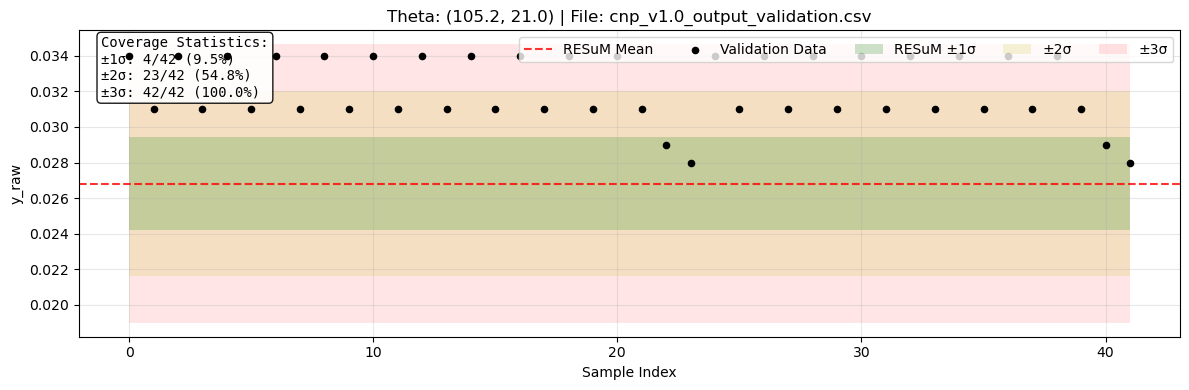

    Coverage statistics for Theta (105.2, 21.0):
    ±1σ: 4/42 (9.5%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 42/42 (100.0%)
  Theta: (40.2, 86.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_40.2_86.0.png


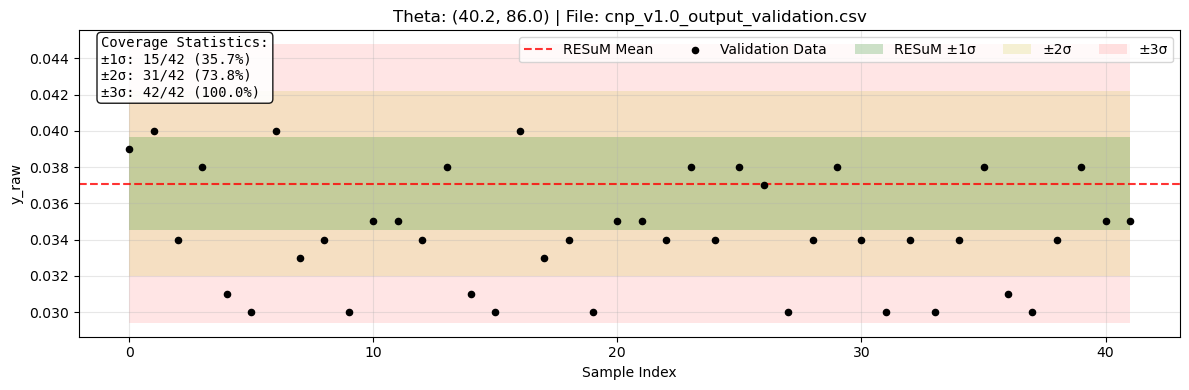

    Coverage statistics for Theta (40.2, 86.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 31/42 (73.8%)
    ±3σ: 42/42 (100.0%)
  Theta: (94.2, 32.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_94.2_32.0.png


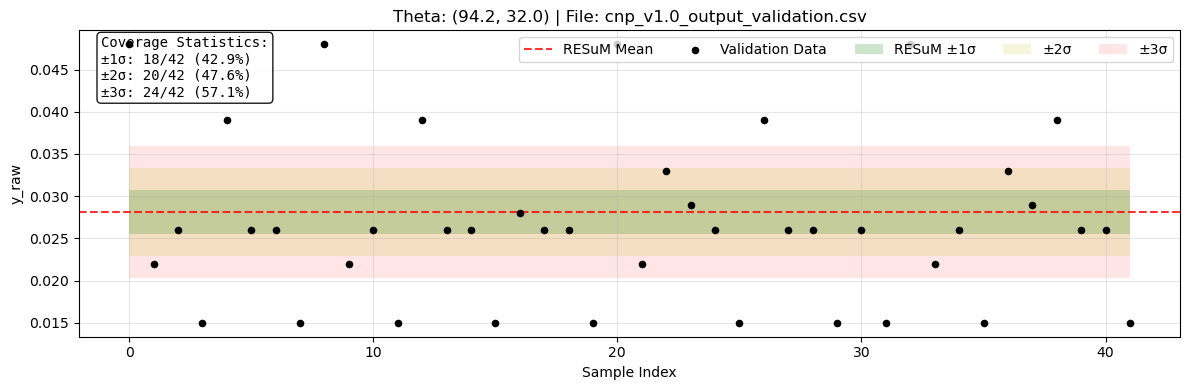

    Coverage statistics for Theta (94.2, 32.0):
    ±1σ: 18/42 (42.9%)
    ±2σ: 20/42 (47.6%)
    ±3σ: 24/42 (57.1%)
  Theta: (43.2, 83.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_43.2_83.0.png


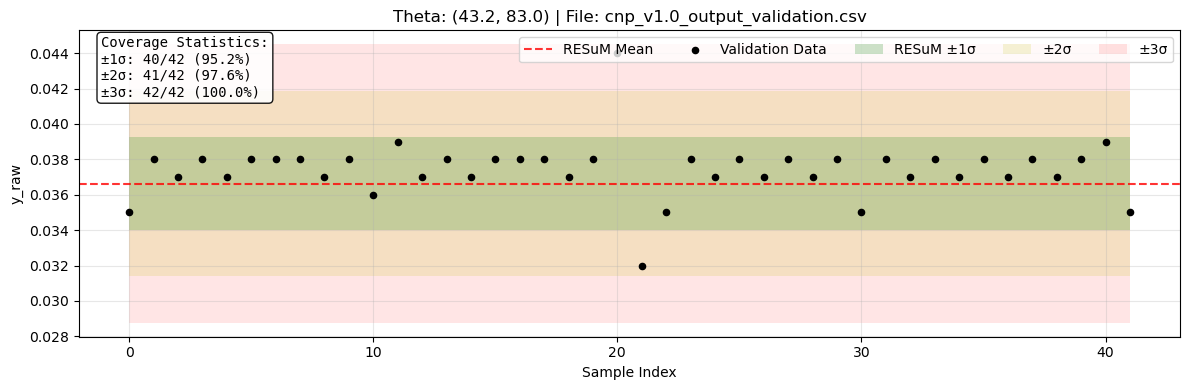

    Coverage statistics for Theta (43.2, 83.0):
    ±1σ: 40/42 (95.2%)
    ±2σ: 41/42 (97.6%)
    ±3σ: 42/42 (100.0%)
  Theta: (99.2, 27.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_99.2_27.0.png


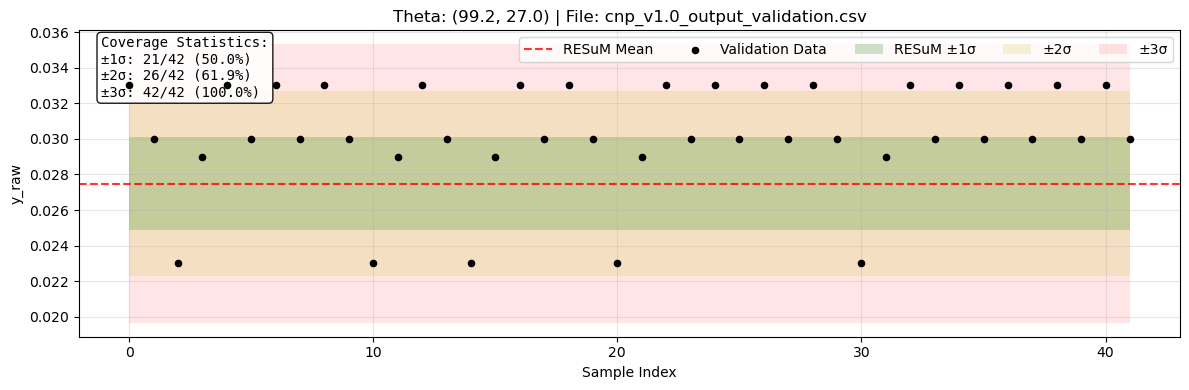

    Coverage statistics for Theta (99.2, 27.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 42/42 (100.0%)
  Theta: (69.2, 57.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_69.2_57.0.png


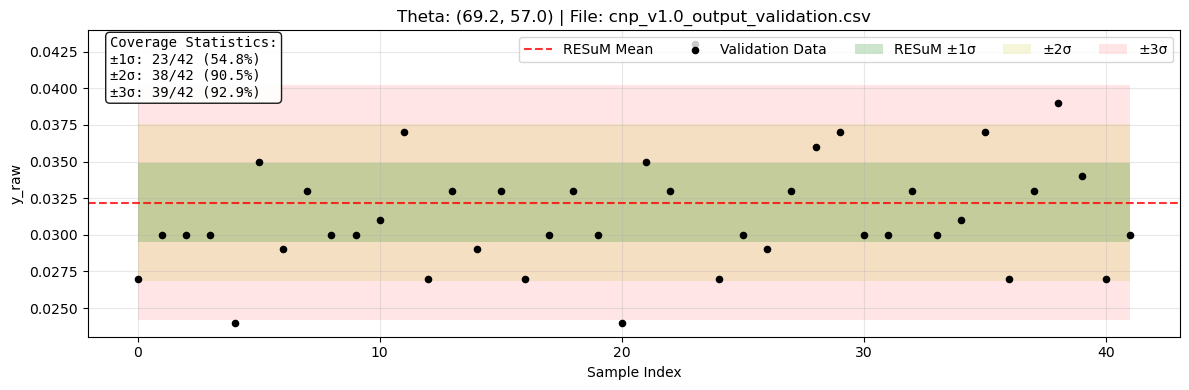

    Coverage statistics for Theta (69.2, 57.0):
    ±1σ: 23/42 (54.8%)
    ±2σ: 38/42 (90.5%)
    ±3σ: 39/42 (92.9%)
  Theta: (83.2, 43.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_83.2_43.0.png


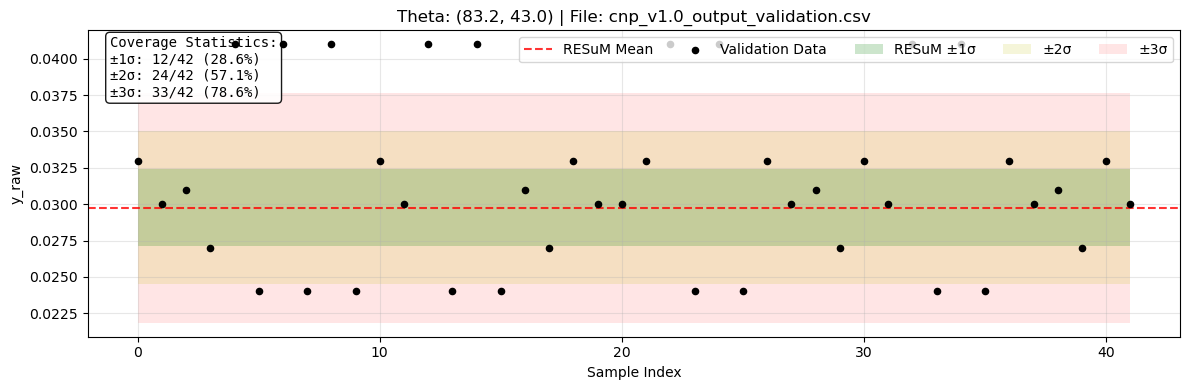

    Coverage statistics for Theta (83.2, 43.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 24/42 (57.1%)
    ±3σ: 33/42 (78.6%)
  Theta: (34.2, 92.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_34.2_92.0.png


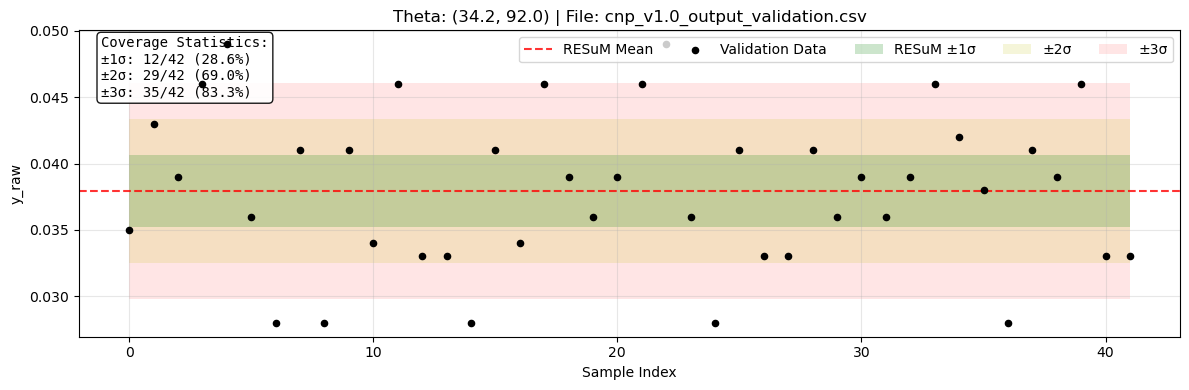

    Coverage statistics for Theta (34.2, 92.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 29/42 (69.0%)
    ±3σ: 35/42 (83.3%)
  Theta: (31.2, 95.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_31.2_95.0.png


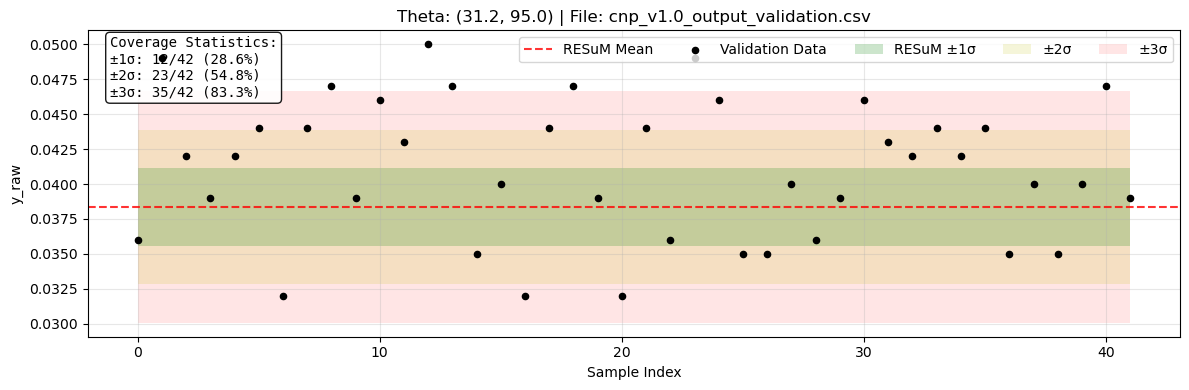

    Coverage statistics for Theta (31.2, 95.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 35/42 (83.3%)
  Theta: (93.2, 33.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_93.2_33.0.png


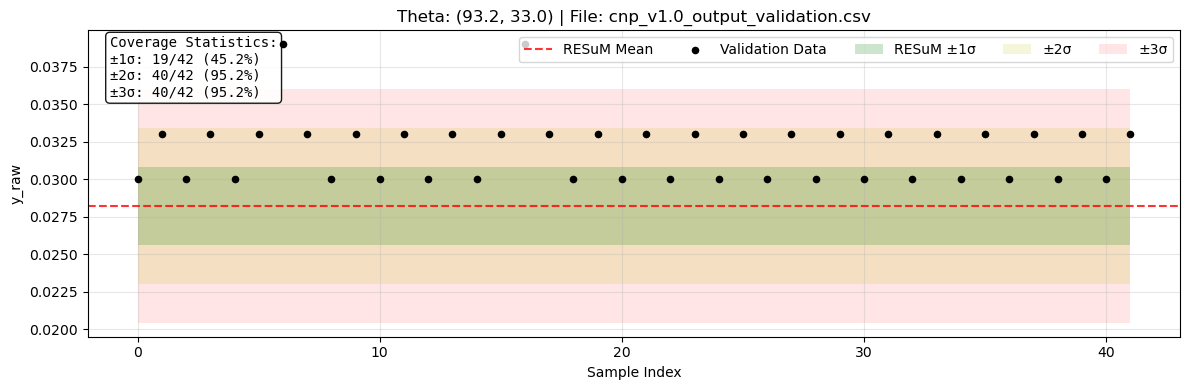

    Coverage statistics for Theta (93.2, 33.0):
    ±1σ: 19/42 (45.2%)
    ±2σ: 40/42 (95.2%)
    ±3σ: 40/42 (95.2%)
  Theta: (107.2, 19.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_107.2_19.0.png


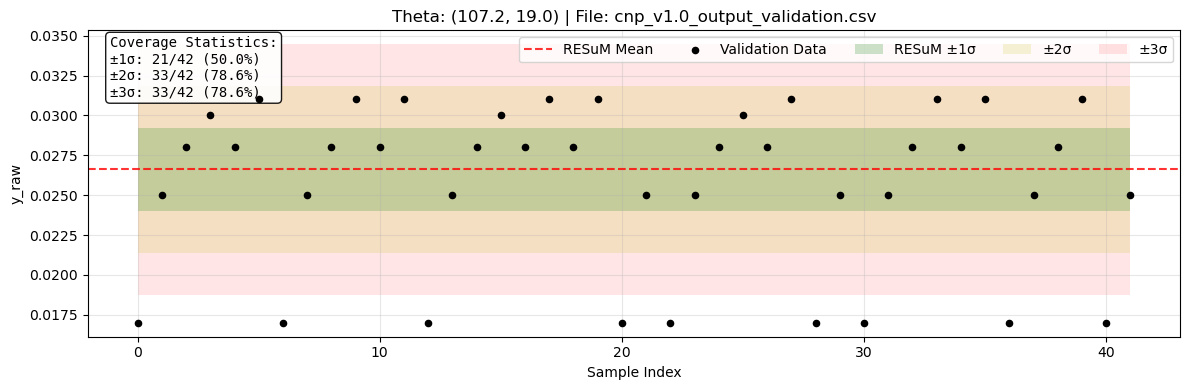

    Coverage statistics for Theta (107.2, 19.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 33/42 (78.6%)
    ±3σ: 33/42 (78.6%)
  Theta: (90.2, 36.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_90.2_36.0.png


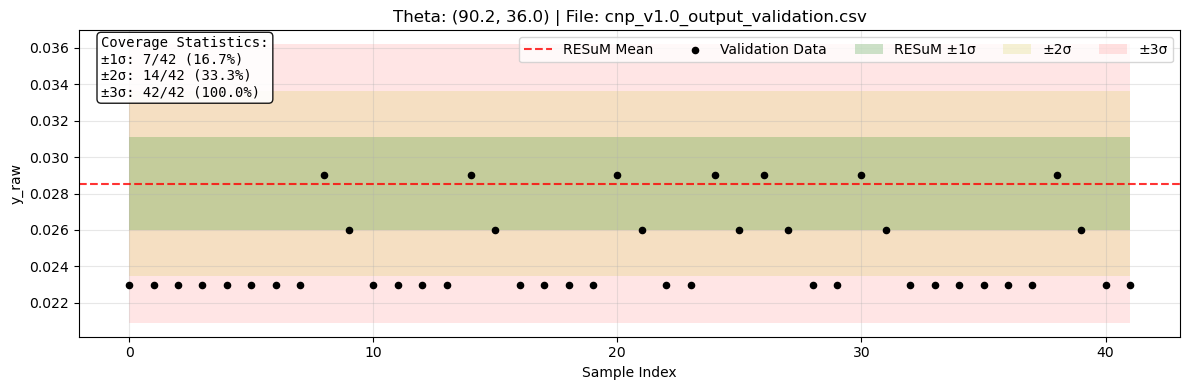

    Coverage statistics for Theta (90.2, 36.0):
    ±1σ: 7/42 (16.7%)
    ±2σ: 14/42 (33.3%)
    ±3σ: 42/42 (100.0%)
  Theta: (67.2, 59.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_67.2_59.0.png


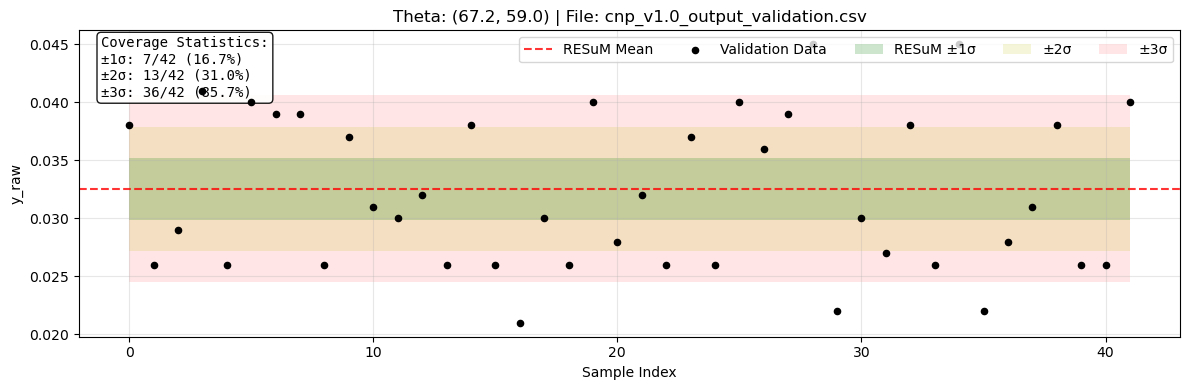

    Coverage statistics for Theta (67.2, 59.0):
    ±1σ: 7/42 (16.7%)
    ±2σ: 13/42 (31.0%)
    ±3σ: 36/42 (85.7%)
  Theta: (52.2, 74.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_52.2_74.0.png


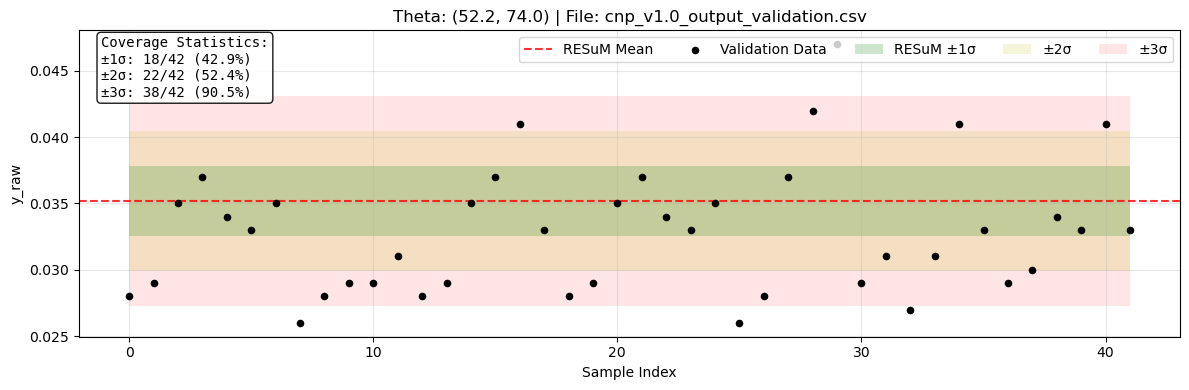

    Coverage statistics for Theta (52.2, 74.0):
    ±1σ: 18/42 (42.9%)
    ±2σ: 22/42 (52.4%)
    ±3σ: 38/42 (90.5%)
  Theta: (80.2, 46.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_80.2_46.0.png


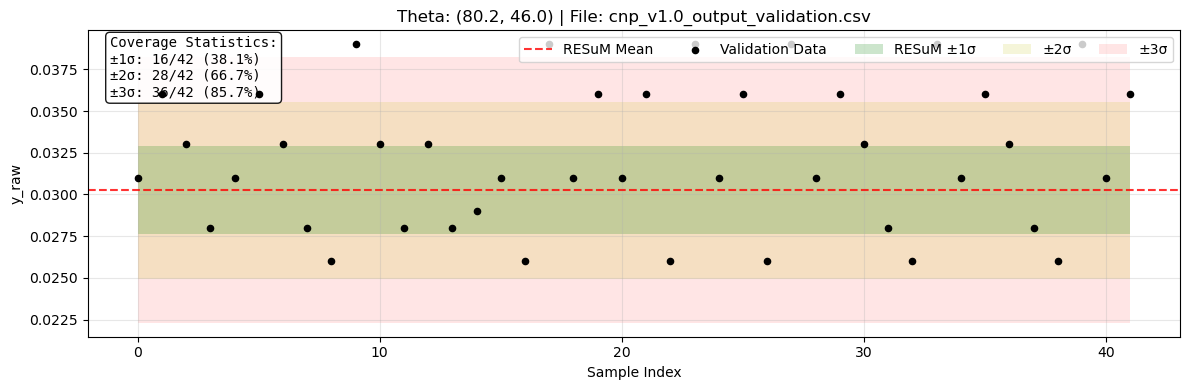

    Coverage statistics for Theta (80.2, 46.0):
    ±1σ: 16/42 (38.1%)
    ±2σ: 28/42 (66.7%)
    ±3σ: 36/42 (85.7%)
  Theta: (61.2, 65.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_61.2_65.0.png


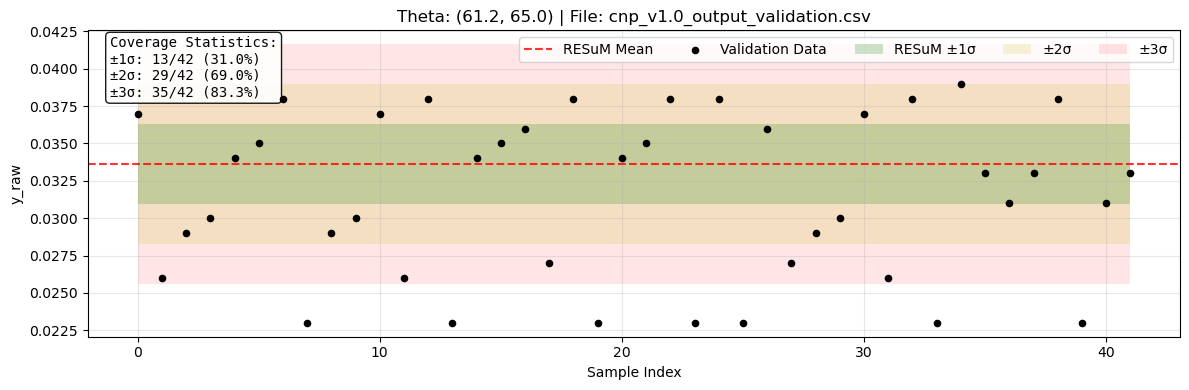

    Coverage statistics for Theta (61.2, 65.0):
    ±1σ: 13/42 (31.0%)
    ±2σ: 29/42 (69.0%)
    ±3σ: 35/42 (83.3%)
  Theta: (82.2, 44.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_82.2_44.0.png


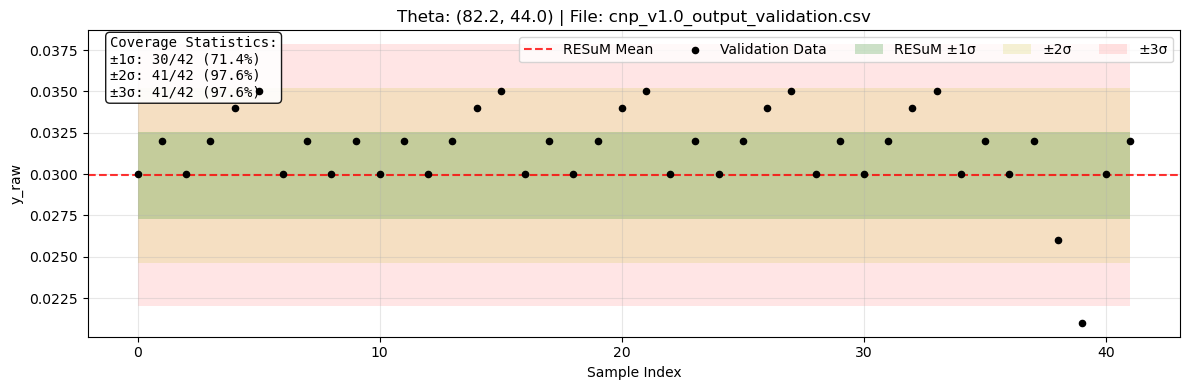

    Coverage statistics for Theta (82.2, 44.0):
    ±1σ: 30/42 (71.4%)
    ±2σ: 41/42 (97.6%)
    ±3σ: 41/42 (97.6%)
  Theta: (63.2, 63.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_63.2_63.0.png


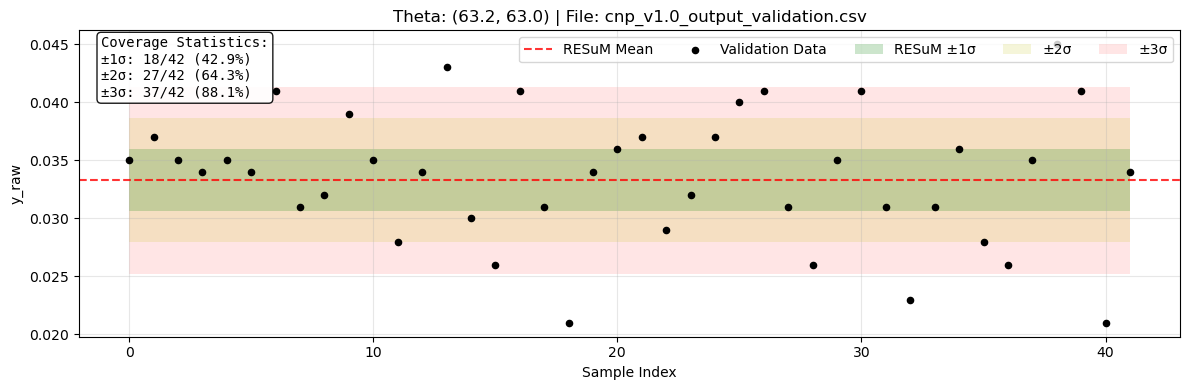

    Coverage statistics for Theta (63.2, 63.0):
    ±1σ: 18/42 (42.9%)
    ±2σ: 27/42 (64.3%)
    ±3σ: 37/42 (88.1%)
  Theta: (102.2, 24.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_102.2_24.0.png


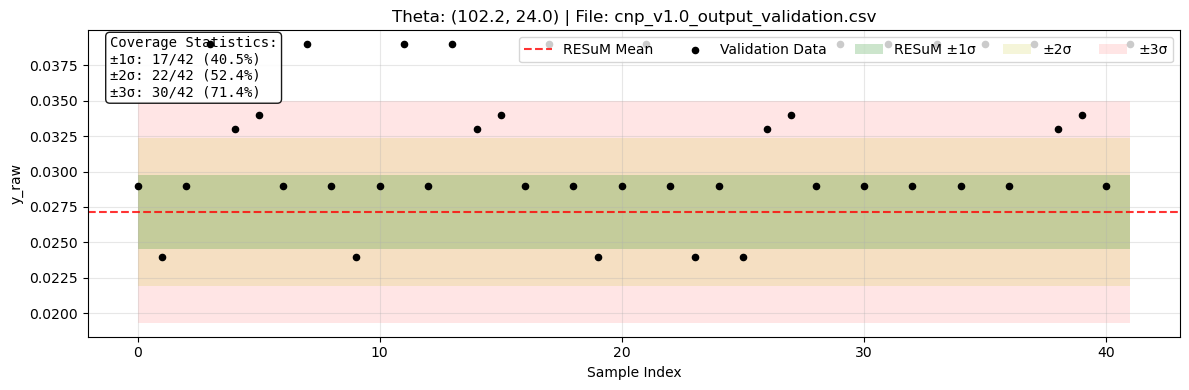

    Coverage statistics for Theta (102.2, 24.0):
    ±1σ: 17/42 (40.5%)
    ±2σ: 22/42 (52.4%)
    ±3σ: 30/42 (71.4%)
  Theta: (27.2, 99.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_27.2_99.0.png


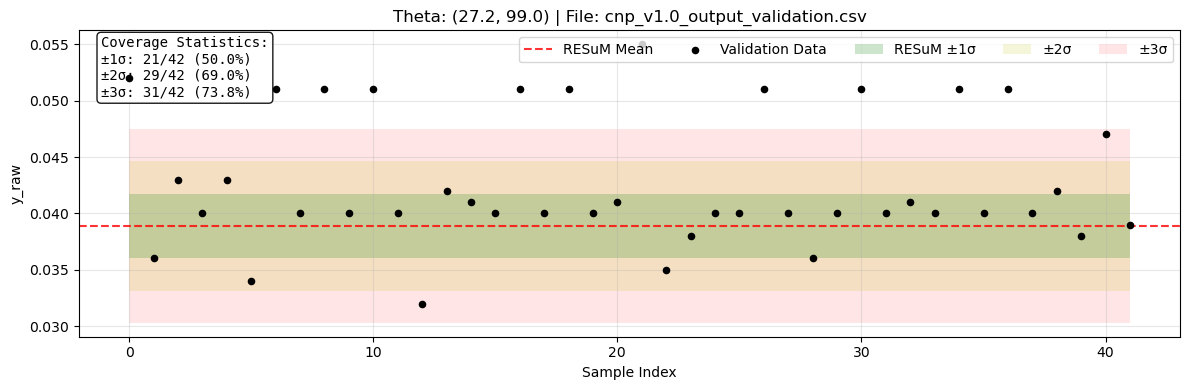

    Coverage statistics for Theta (27.2, 99.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 29/42 (69.0%)
    ±3σ: 31/42 (73.8%)
  Theta: (49.2, 77.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_49.2_77.0.png


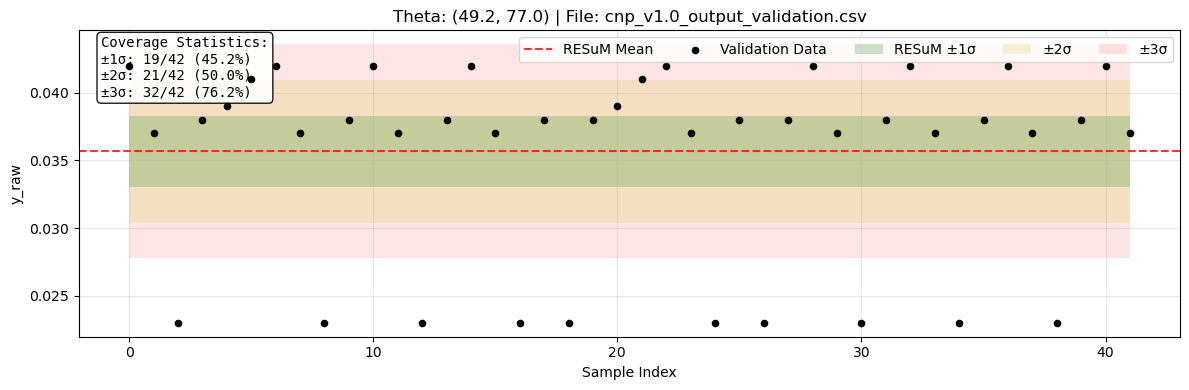

    Coverage statistics for Theta (49.2, 77.0):
    ±1σ: 19/42 (45.2%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 32/42 (76.2%)
  Theta: (28.2, 98.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_28.2_98.0.png


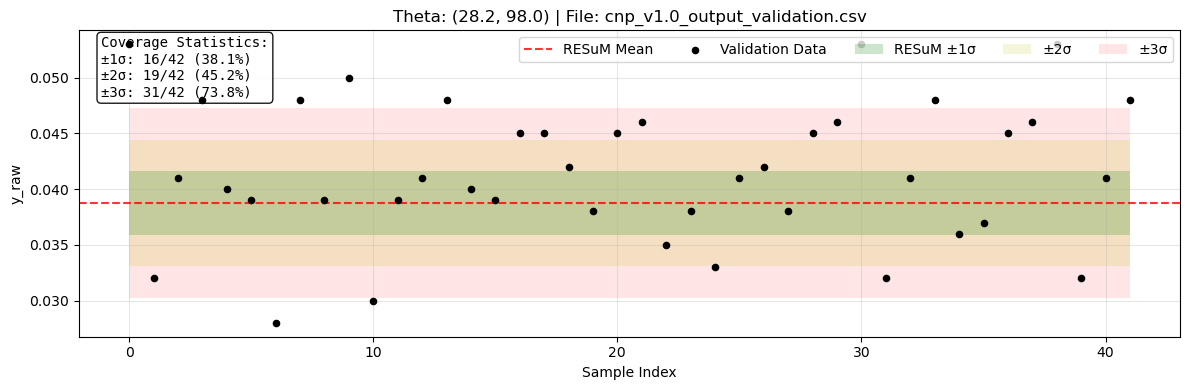

    Coverage statistics for Theta (28.2, 98.0):
    ±1σ: 16/42 (38.1%)
    ±2σ: 19/42 (45.2%)
    ±3σ: 31/42 (73.8%)
  Theta: (110.2, 16.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_110.2_16.0.png


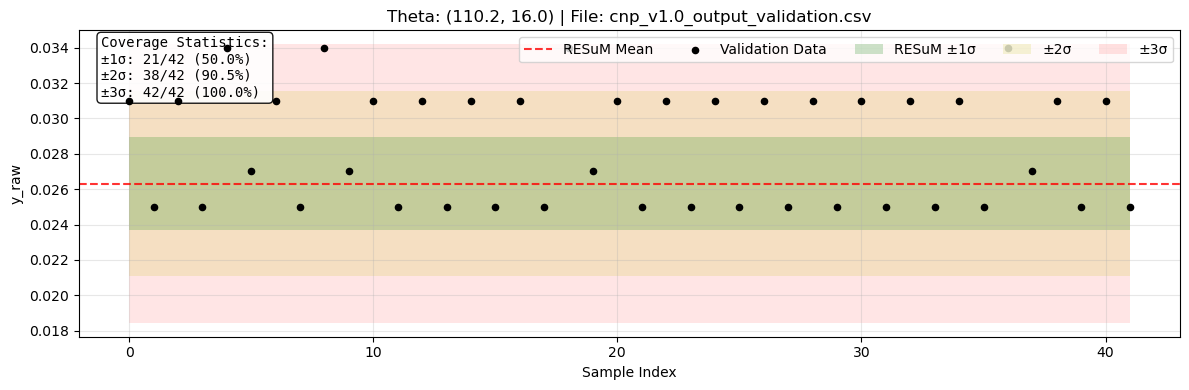

    Coverage statistics for Theta (110.2, 16.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 38/42 (90.5%)
    ±3σ: 42/42 (100.0%)
  Theta: (75.2, 51.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_75.2_51.0.png


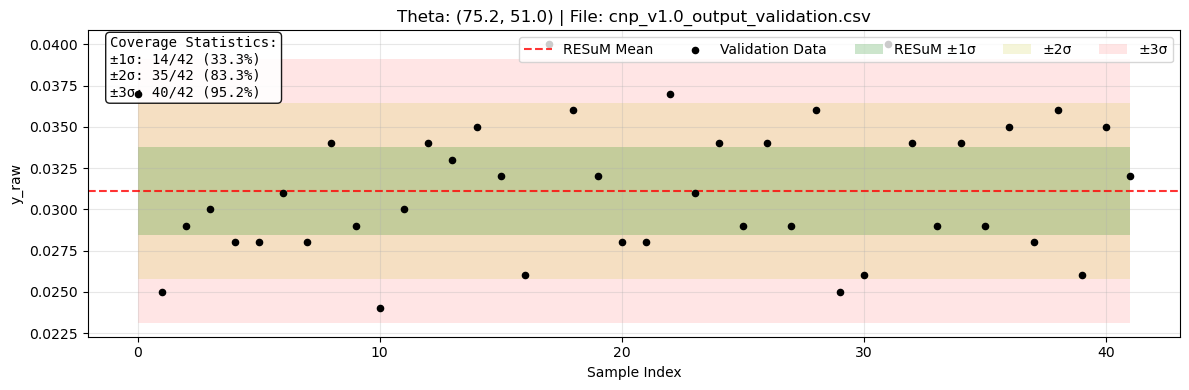

    Coverage statistics for Theta (75.2, 51.0):
    ±1σ: 14/42 (33.3%)
    ±2σ: 35/42 (83.3%)
    ±3σ: 40/42 (95.2%)
  Theta: (79.2, 47.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_79.2_47.0.png


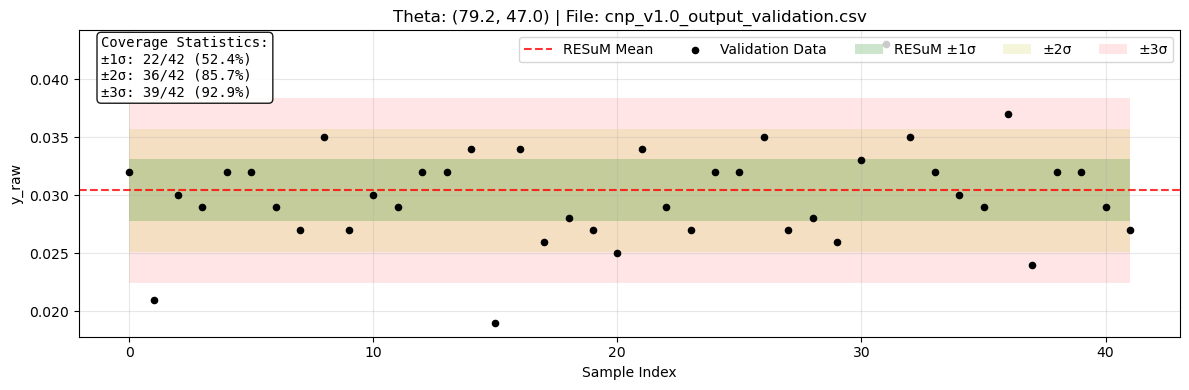

    Coverage statistics for Theta (79.2, 47.0):
    ±1σ: 22/42 (52.4%)
    ±2σ: 36/42 (85.7%)
    ±3σ: 39/42 (92.9%)
  Theta: (98.2, 28.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_98.2_28.0.png


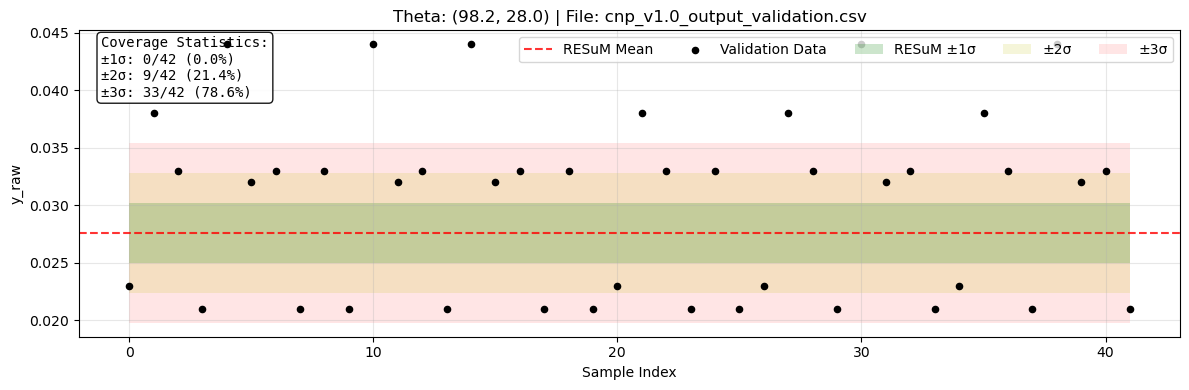

    Coverage statistics for Theta (98.2, 28.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 9/42 (21.4%)
    ±3σ: 33/42 (78.6%)
  Theta: (85.2, 41.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_85.2_41.0.png


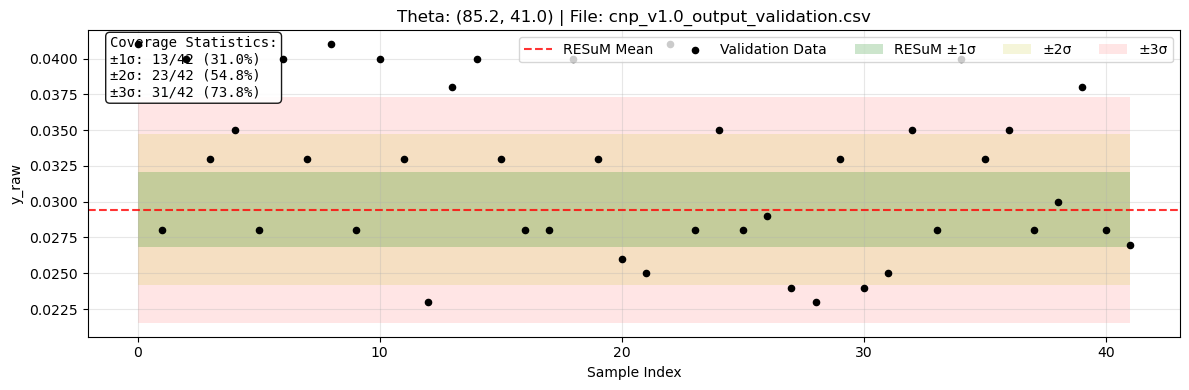

    Coverage statistics for Theta (85.2, 41.0):
    ±1σ: 13/42 (31.0%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 31/42 (73.8%)
  Theta: (68.2, 58.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_68.2_58.0.png


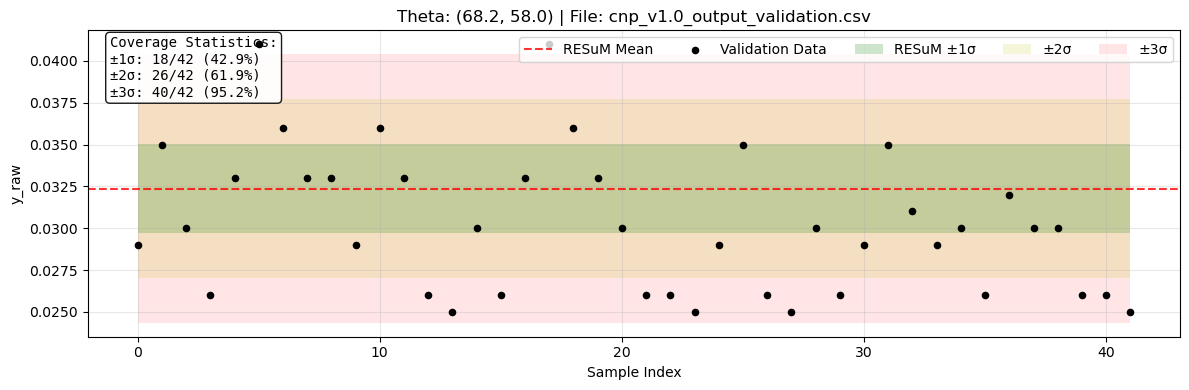

    Coverage statistics for Theta (68.2, 58.0):
    ±1σ: 18/42 (42.9%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 40/42 (95.2%)
  Theta: (104.2, 22.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_104.2_22.0.png


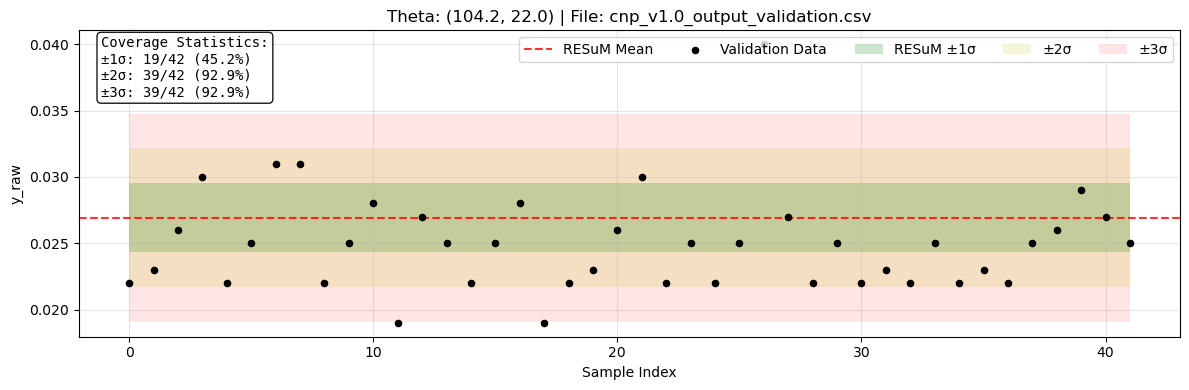

    Coverage statistics for Theta (104.2, 22.0):
    ±1σ: 19/42 (45.2%)
    ±2σ: 39/42 (92.9%)
    ±3σ: 39/42 (92.9%)
  Theta: (57.2, 69.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_57.2_69.0.png


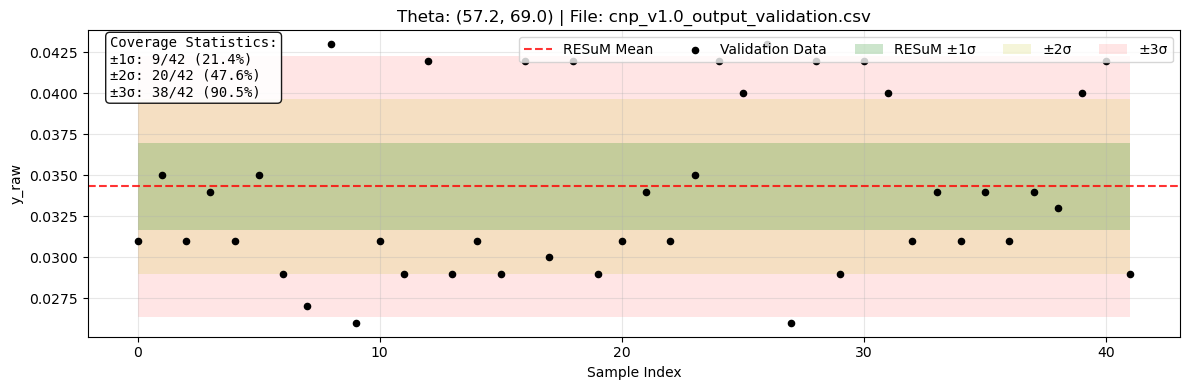

    Coverage statistics for Theta (57.2, 69.0):
    ±1σ: 9/42 (21.4%)
    ±2σ: 20/42 (47.6%)
    ±3σ: 38/42 (90.5%)
  Theta: (32.2, 94.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_32.2_94.0.png


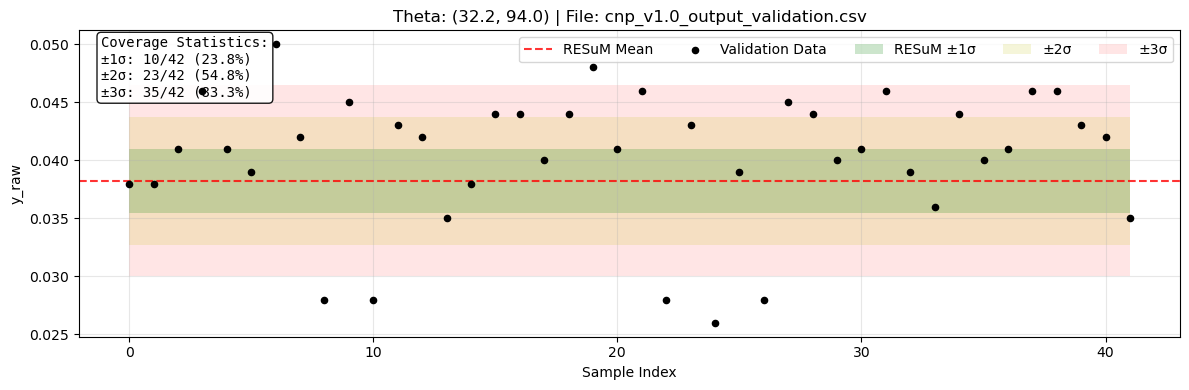

    Coverage statistics for Theta (32.2, 94.0):
    ±1σ: 10/42 (23.8%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 35/42 (83.3%)
  Theta: (38.2, 88.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_38.2_88.0.png


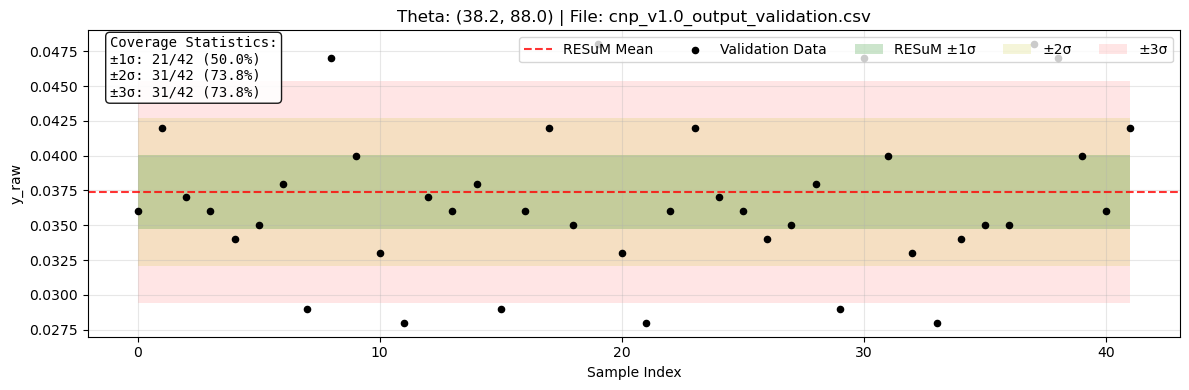

    Coverage statistics for Theta (38.2, 88.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 31/42 (73.8%)
    ±3σ: 31/42 (73.8%)
  Theta: (73.2, 53.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_73.2_53.0.png


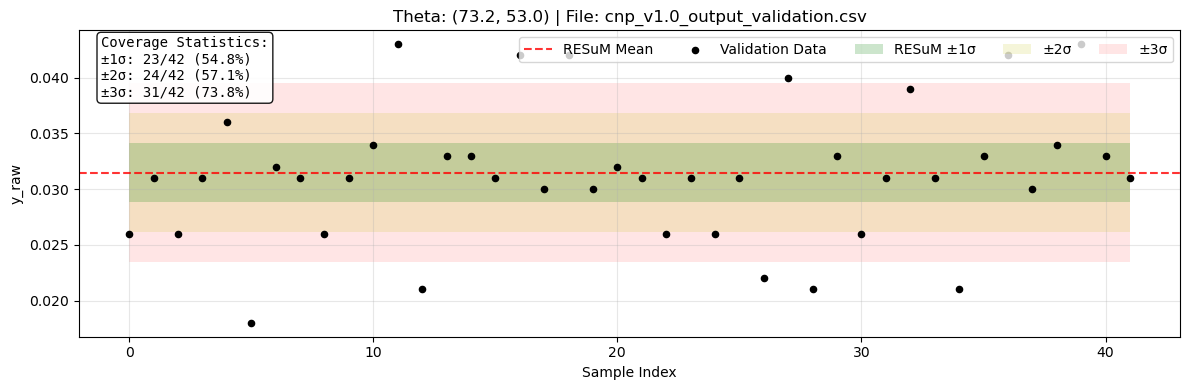

    Coverage statistics for Theta (73.2, 53.0):
    ±1σ: 23/42 (54.8%)
    ±2σ: 24/42 (57.1%)
    ±3σ: 31/42 (73.8%)
  Theta: (45.2, 81.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_45.2_81.0.png


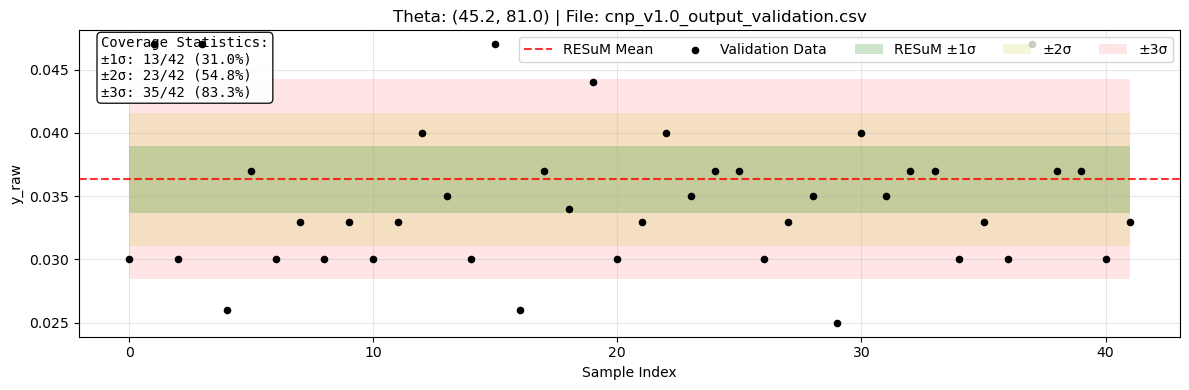

    Coverage statistics for Theta (45.2, 81.0):
    ±1σ: 13/42 (31.0%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 35/42 (83.3%)
  Theta: (112.2, 14.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_112.2_14.0.png


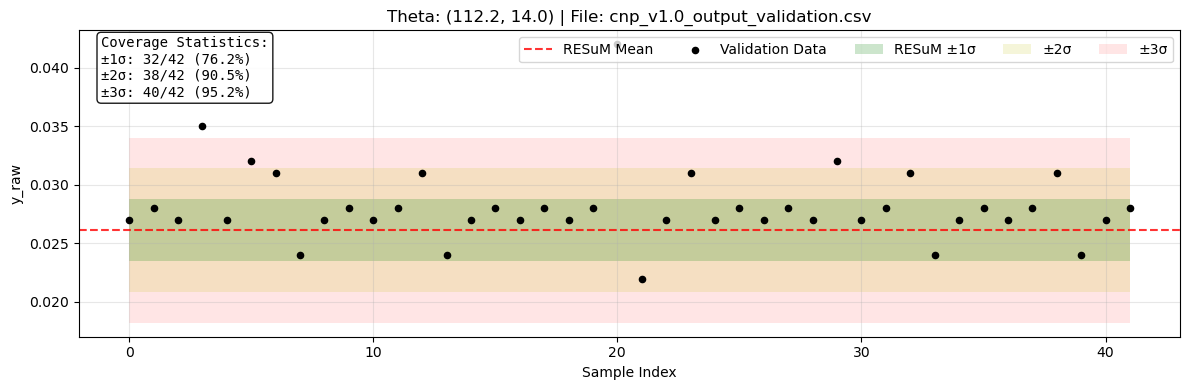

    Coverage statistics for Theta (112.2, 14.0):
    ±1σ: 32/42 (76.2%)
    ±2σ: 38/42 (90.5%)
    ±3σ: 40/42 (95.2%)
  Theta: (53.2, 73.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_53.2_73.0.png


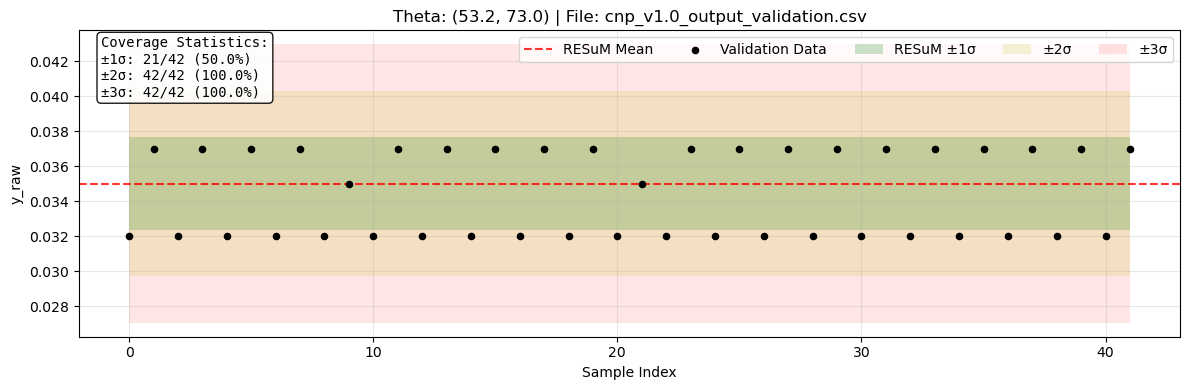

    Coverage statistics for Theta (53.2, 73.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 42/42 (100.0%)
    ±3σ: 42/42 (100.0%)
  Theta: (44.2, 82.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_44.2_82.0.png


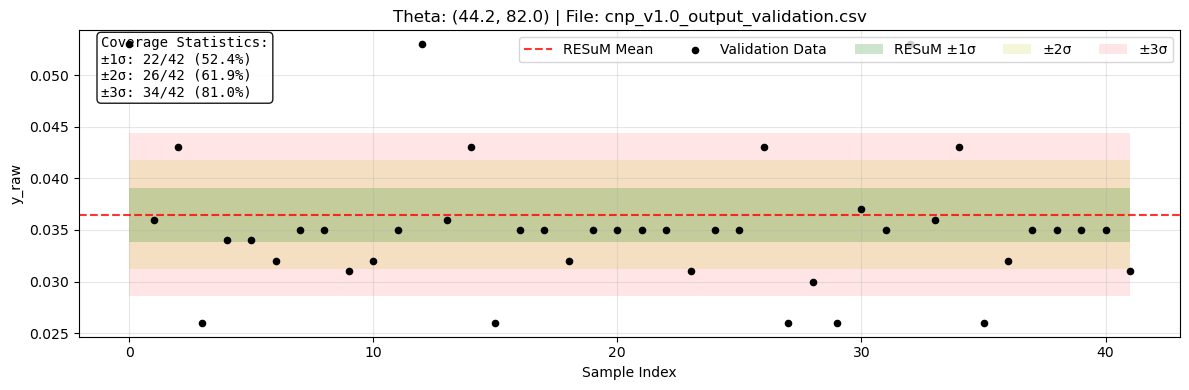

    Coverage statistics for Theta (44.2, 82.0):
    ±1σ: 22/42 (52.4%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 34/42 (81.0%)
  Theta: (18.2, 108.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_18.2_108.0.png


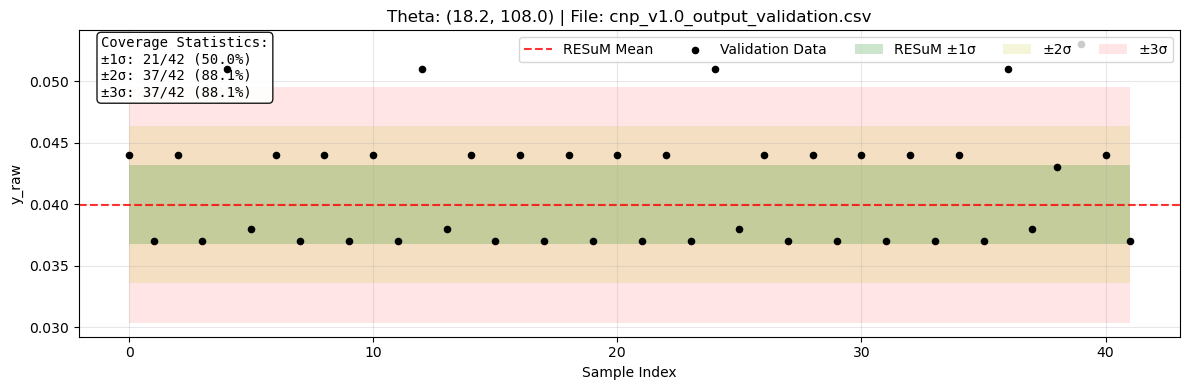

    Coverage statistics for Theta (18.2, 108.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 37/42 (88.1%)
    ±3σ: 37/42 (88.1%)
  Theta: (23.2, 103.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_23.2_103.0.png


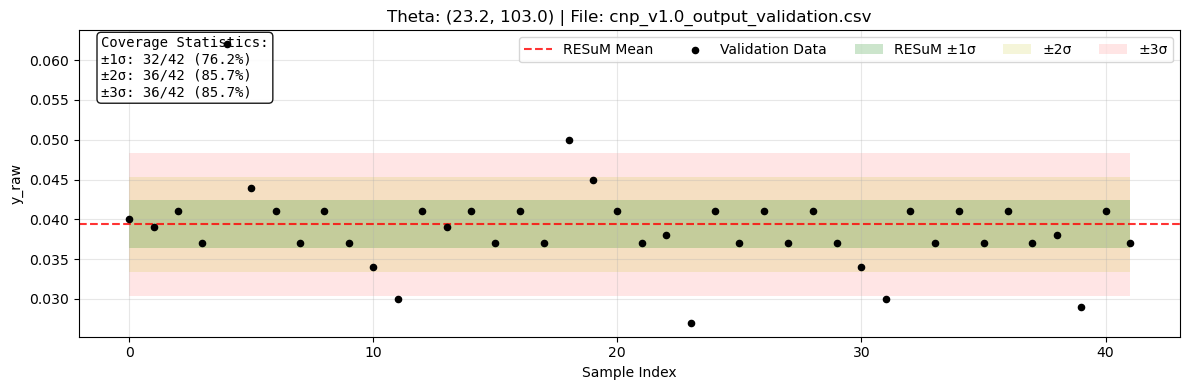

    Coverage statistics for Theta (23.2, 103.0):
    ±1σ: 32/42 (76.2%)
    ±2σ: 36/42 (85.7%)
    ±3σ: 36/42 (85.7%)
  Theta: (60.2, 66.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_60.2_66.0.png


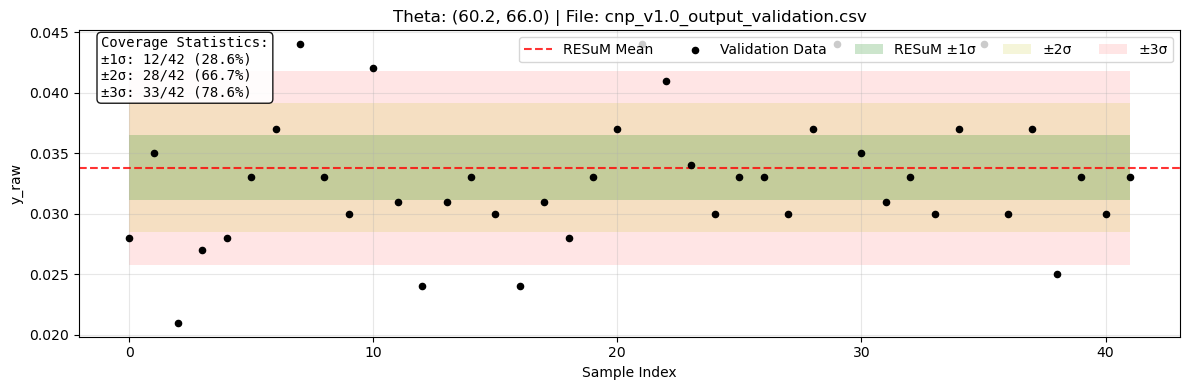

    Coverage statistics for Theta (60.2, 66.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 28/42 (66.7%)
    ±3σ: 33/42 (78.6%)
  Theta: (84.2, 42.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_84.2_42.0.png


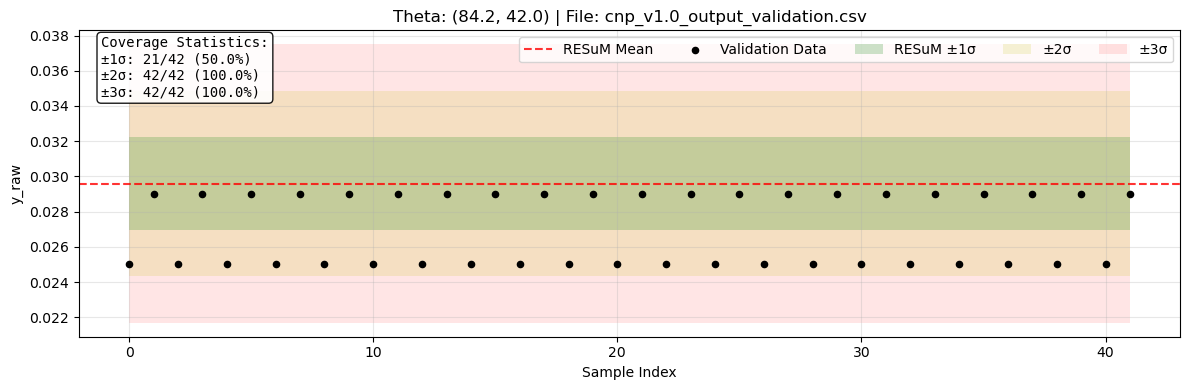

    Coverage statistics for Theta (84.2, 42.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 42/42 (100.0%)
    ±3σ: 42/42 (100.0%)
  Theta: (64.2, 62.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_64.2_62.0.png


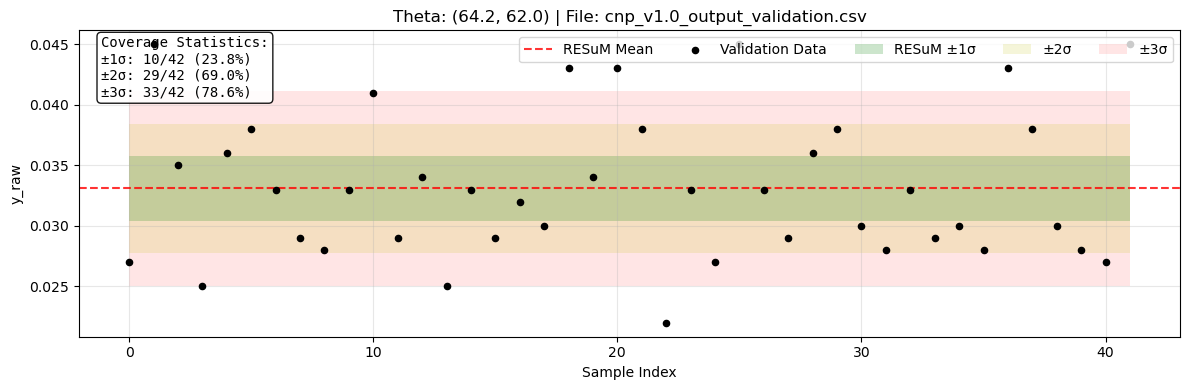

    Coverage statistics for Theta (64.2, 62.0):
    ±1σ: 10/42 (23.8%)
    ±2σ: 29/42 (69.0%)
    ±3σ: 33/42 (78.6%)
  Theta: (35.2, 91.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_35.2_91.0.png


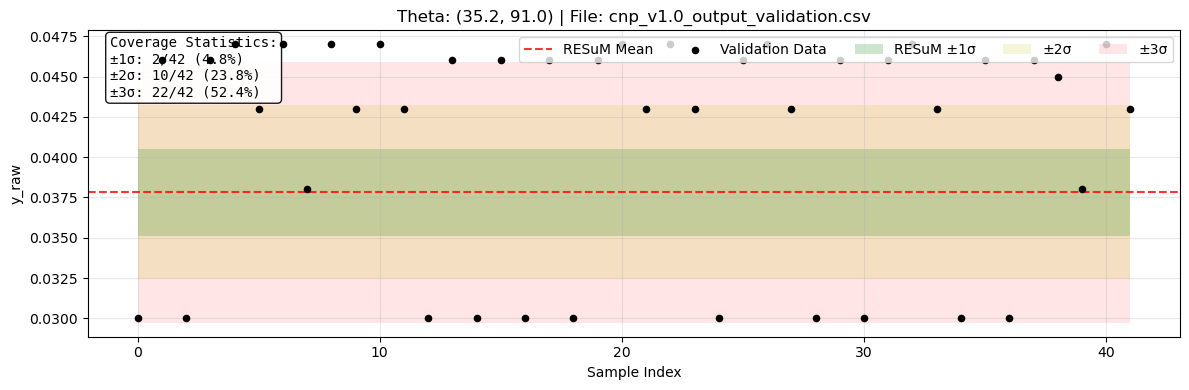

    Coverage statistics for Theta (35.2, 91.0):
    ±1σ: 2/42 (4.8%)
    ±2σ: 10/42 (23.8%)
    ±3σ: 22/42 (52.4%)
  Theta: (71.2, 55.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_71.2_55.0.png


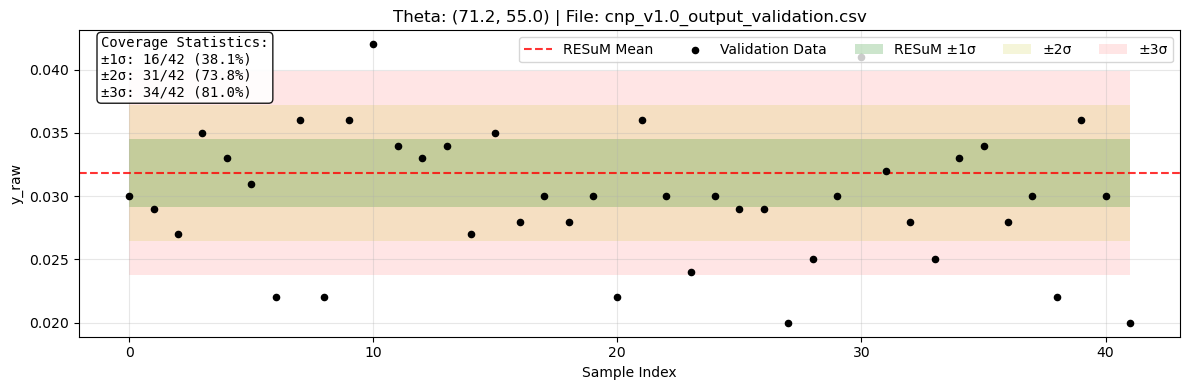

    Coverage statistics for Theta (71.2, 55.0):
    ±1σ: 16/42 (38.1%)
    ±2σ: 31/42 (73.8%)
    ±3σ: 34/42 (81.0%)
  Theta: (58.2, 68.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_58.2_68.0.png


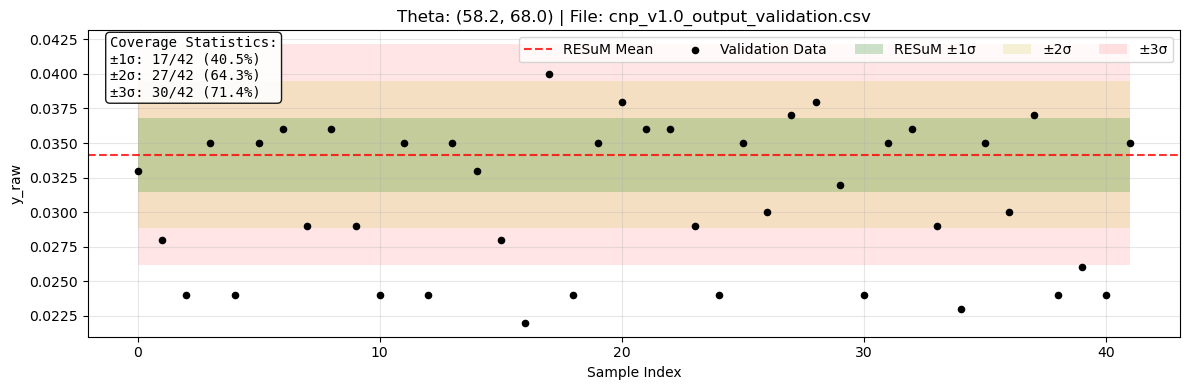

    Coverage statistics for Theta (58.2, 68.0):
    ±1σ: 17/42 (40.5%)
    ±2σ: 27/42 (64.3%)
    ±3σ: 30/42 (71.4%)
  Theta: (100.2, 26.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_100.2_26.0.png


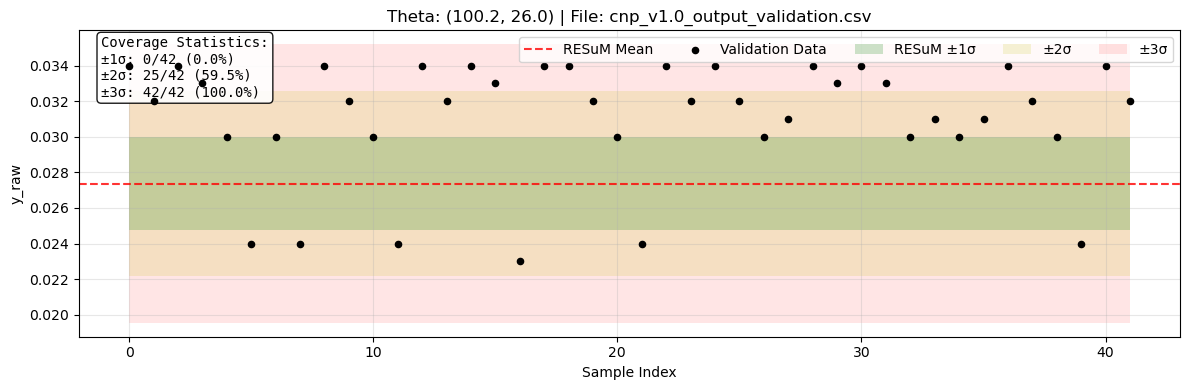

    Coverage statistics for Theta (100.2, 26.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 25/42 (59.5%)
    ±3σ: 42/42 (100.0%)
  Theta: (109.2, 17.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_109.2_17.0.png


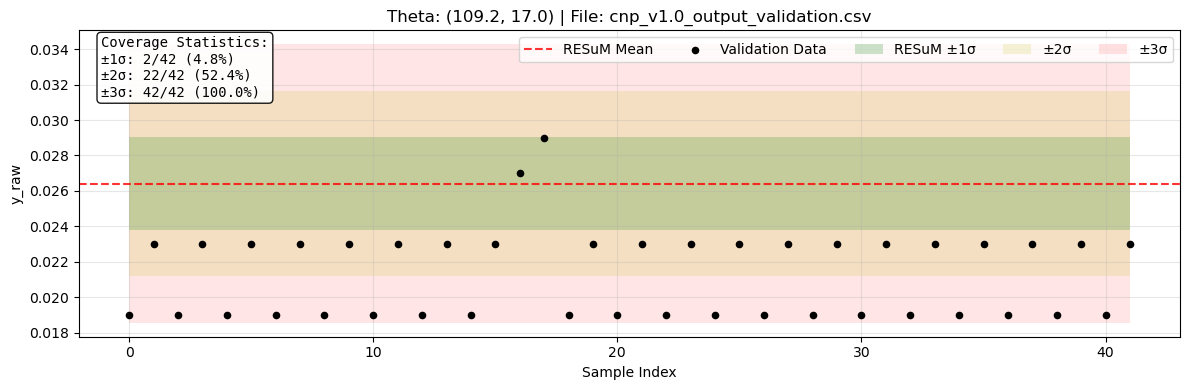

    Coverage statistics for Theta (109.2, 17.0):
    ±1σ: 2/42 (4.8%)
    ±2σ: 22/42 (52.4%)
    ±3σ: 42/42 (100.0%)
  Theta: (47.2, 79.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_47.2_79.0.png


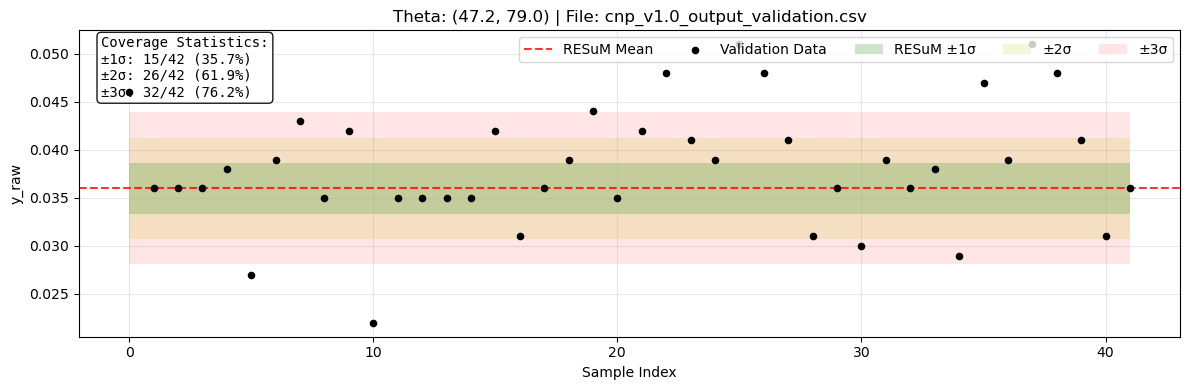

    Coverage statistics for Theta (47.2, 79.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 32/42 (76.2%)
  Theta: (17.2, 109.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_17.2_109.0.png


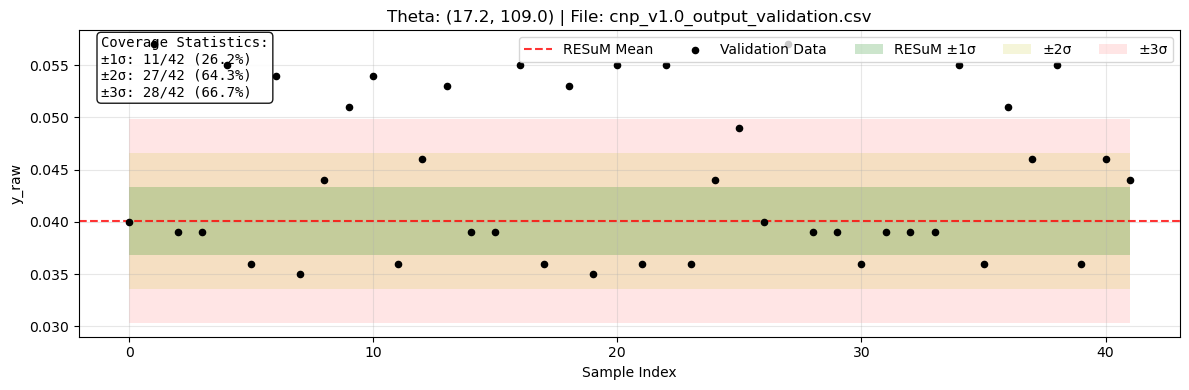

    Coverage statistics for Theta (17.2, 109.0):
    ±1σ: 11/42 (26.2%)
    ±2σ: 27/42 (64.3%)
    ±3σ: 28/42 (66.7%)
  Theta: (70.2, 56.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_70.2_56.0.png


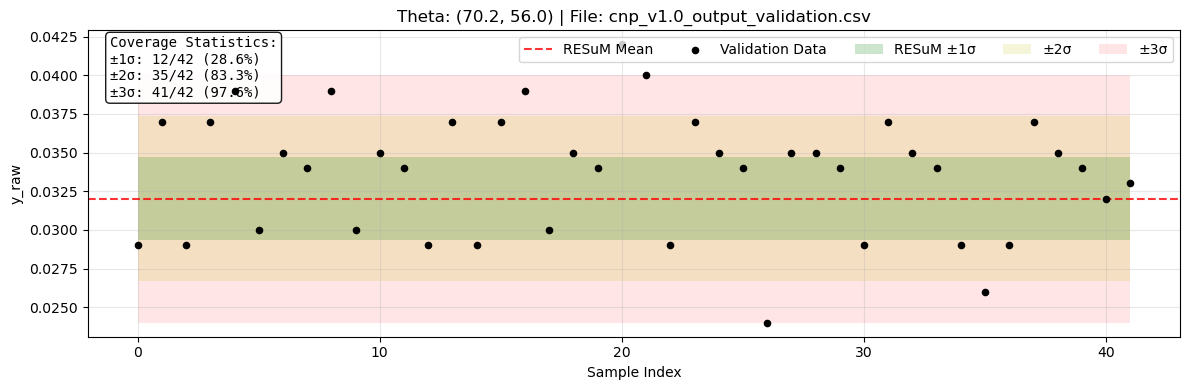

    Coverage statistics for Theta (70.2, 56.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 35/42 (83.3%)
    ±3σ: 41/42 (97.6%)
  Theta: (89.2, 37.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_89.2_37.0.png


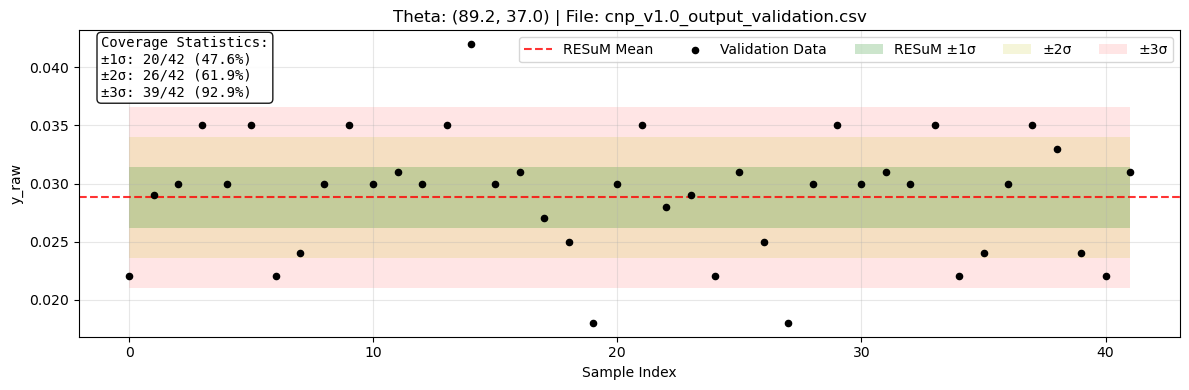

    Coverage statistics for Theta (89.2, 37.0):
    ±1σ: 20/42 (47.6%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 39/42 (92.9%)
  Theta: (29.2, 97.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_29.2_97.0.png


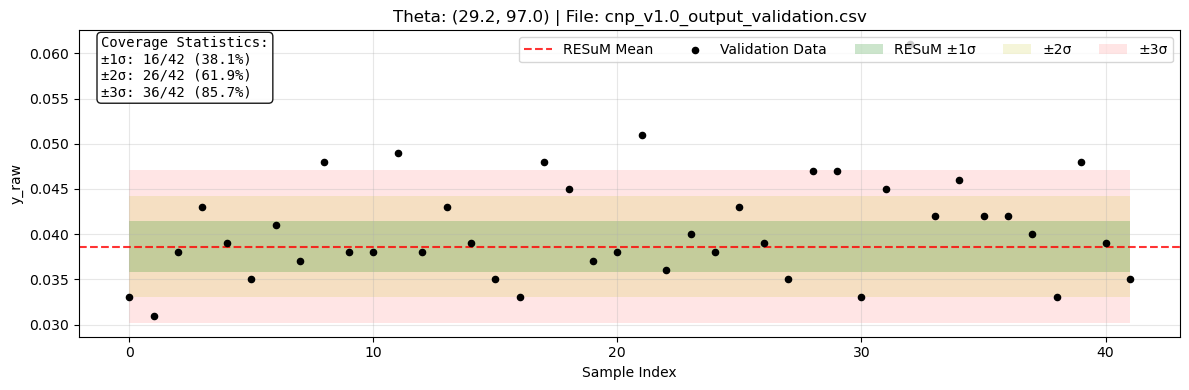

    Coverage statistics for Theta (29.2, 97.0):
    ±1σ: 16/42 (38.1%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 36/42 (85.7%)
  Theta: (77.2, 49.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_77.2_49.0.png


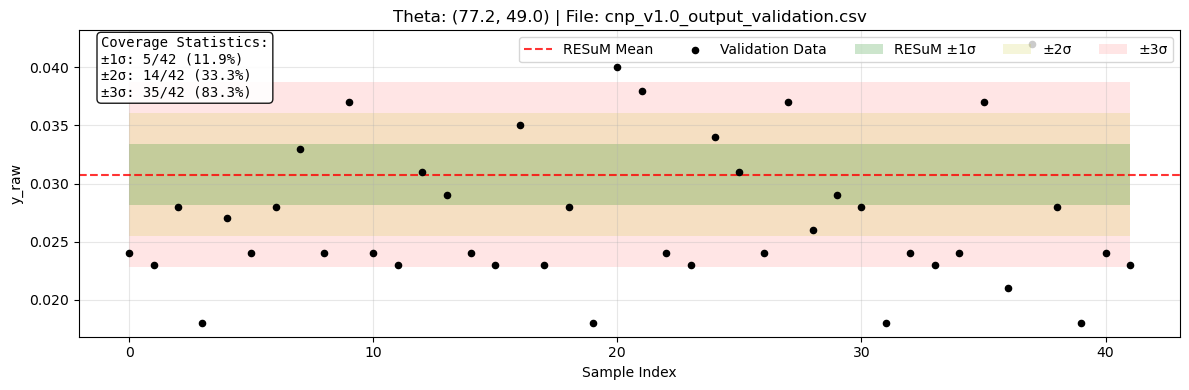

    Coverage statistics for Theta (77.2, 49.0):
    ±1σ: 5/42 (11.9%)
    ±2σ: 14/42 (33.3%)
    ±3σ: 35/42 (83.3%)
  Theta: (48.2, 78.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_48.2_78.0.png


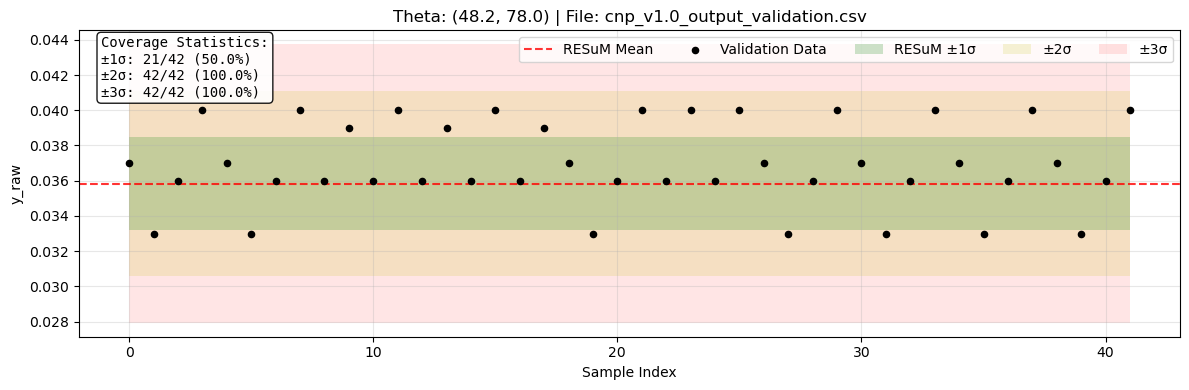

    Coverage statistics for Theta (48.2, 78.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 42/42 (100.0%)
    ±3σ: 42/42 (100.0%)
  Theta: (50.2, 76.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_50.2_76.0.png


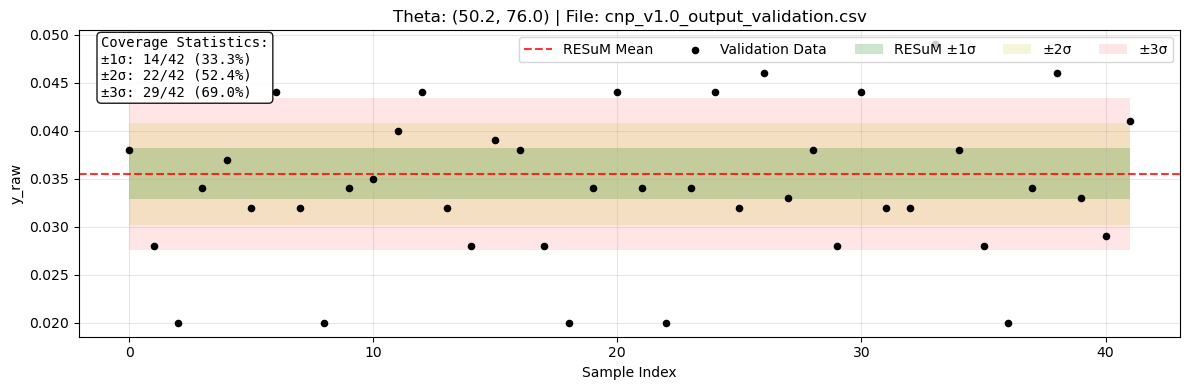

    Coverage statistics for Theta (50.2, 76.0):
    ±1σ: 14/42 (33.3%)
    ±2σ: 22/42 (52.4%)
    ±3σ: 29/42 (69.0%)
  Theta: (81.2, 45.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_81.2_45.0.png


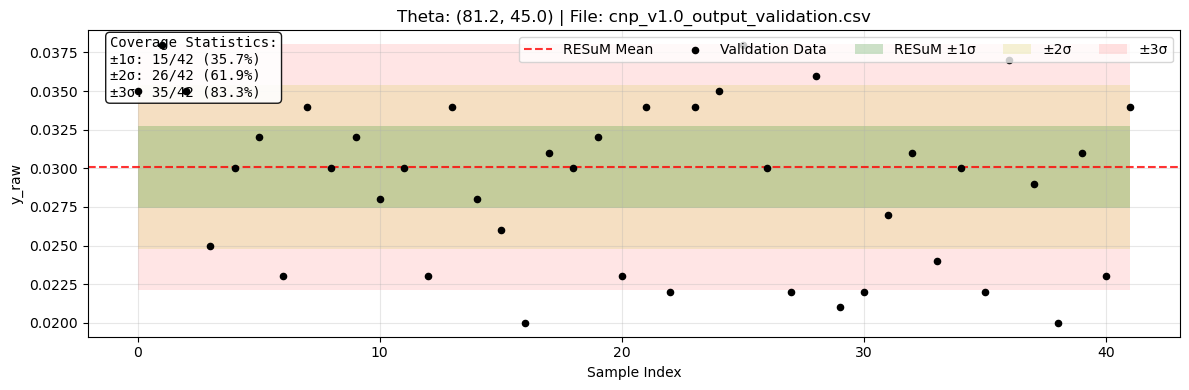

    Coverage statistics for Theta (81.2, 45.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 35/42 (83.3%)
  Theta: (103.2, 23.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_103.2_23.0.png


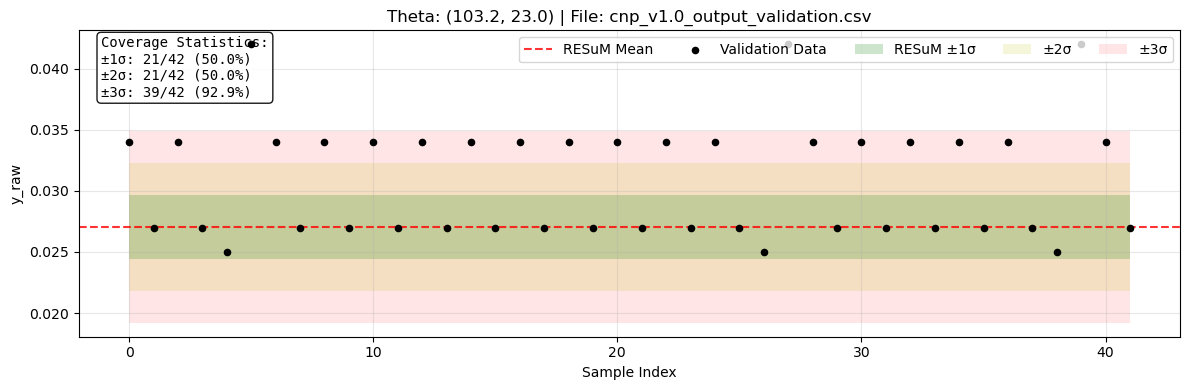

    Coverage statistics for Theta (103.2, 23.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 39/42 (92.9%)
  Theta: (113.2, 13.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_113.2_13.0.png


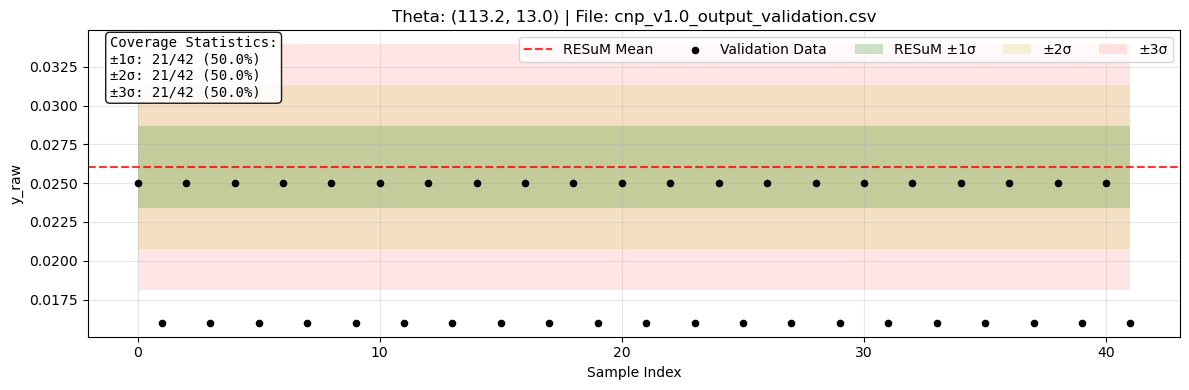

    Coverage statistics for Theta (113.2, 13.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 21/42 (50.0%)
  Theta: (108.2, 18.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_108.2_18.0.png


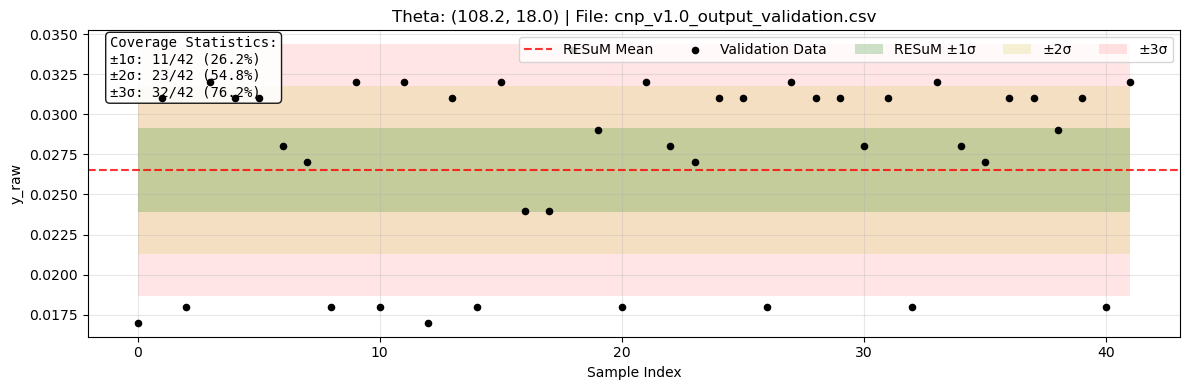

    Coverage statistics for Theta (108.2, 18.0):
    ±1σ: 11/42 (26.2%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 32/42 (76.2%)
  Theta: (62.2, 64.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_62.2_64.0.png


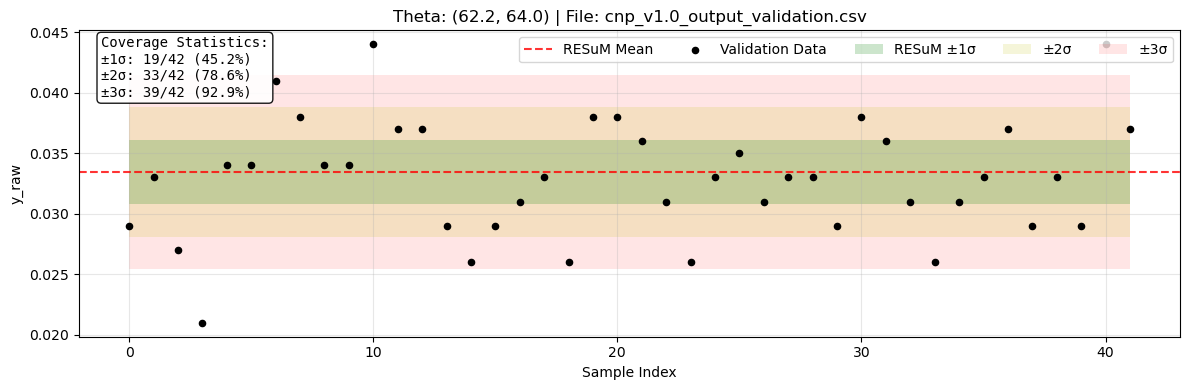

    Coverage statistics for Theta (62.2, 64.0):
    ±1σ: 19/42 (45.2%)
    ±2σ: 33/42 (78.6%)
    ±3σ: 39/42 (92.9%)
  Theta: (20.2, 106.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_20.2_106.0.png


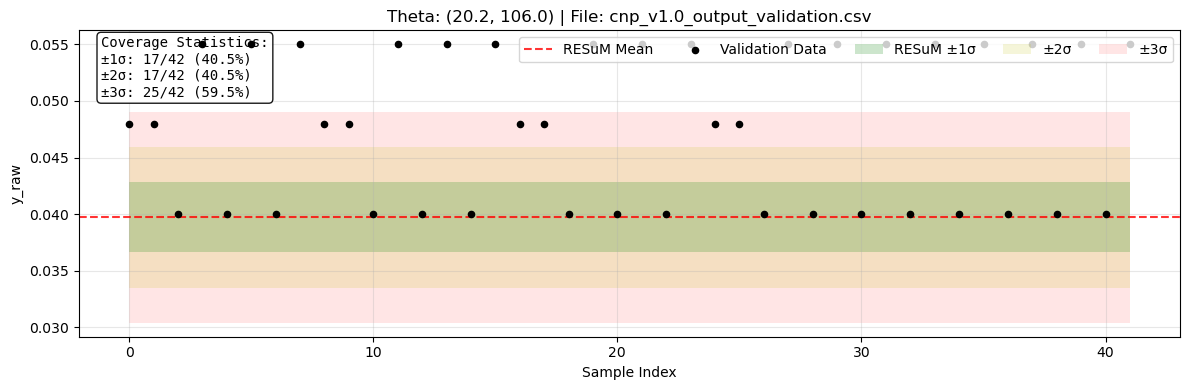

    Coverage statistics for Theta (20.2, 106.0):
    ±1σ: 17/42 (40.5%)
    ±2σ: 17/42 (40.5%)
    ±3σ: 25/42 (59.5%)
  Theta: (97.2, 29.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_97.2_29.0.png


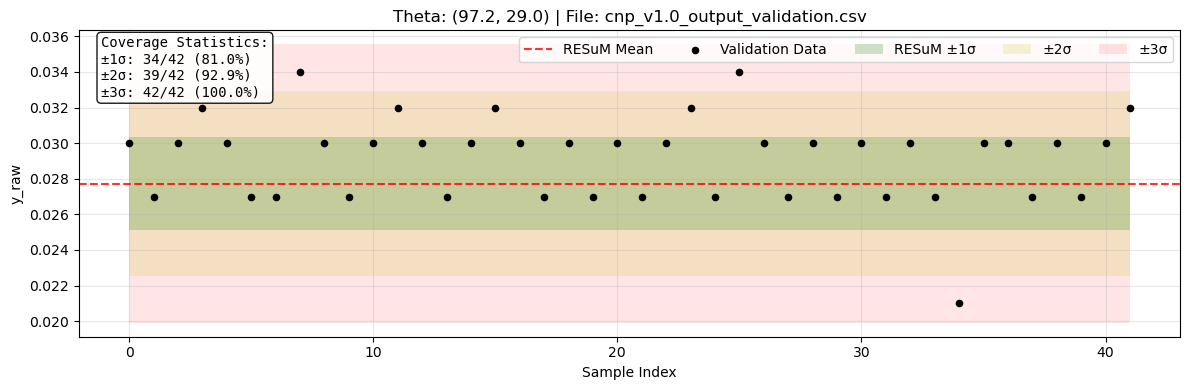

    Coverage statistics for Theta (97.2, 29.0):
    ±1σ: 34/42 (81.0%)
    ±2σ: 39/42 (92.9%)
    ±3σ: 42/42 (100.0%)
  Theta: (65.2, 61.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_65.2_61.0.png


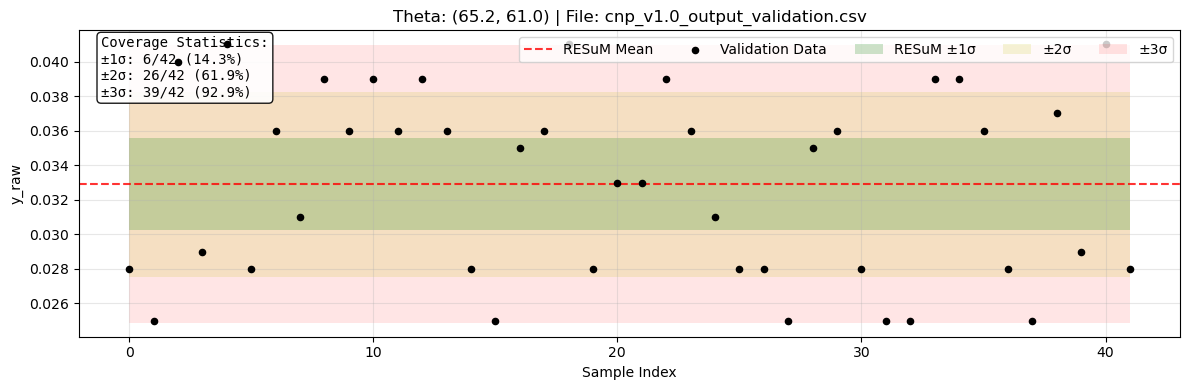

    Coverage statistics for Theta (65.2, 61.0):
    ±1σ: 6/42 (14.3%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 39/42 (92.9%)
  Theta: (87.2, 39.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_87.2_39.0.png


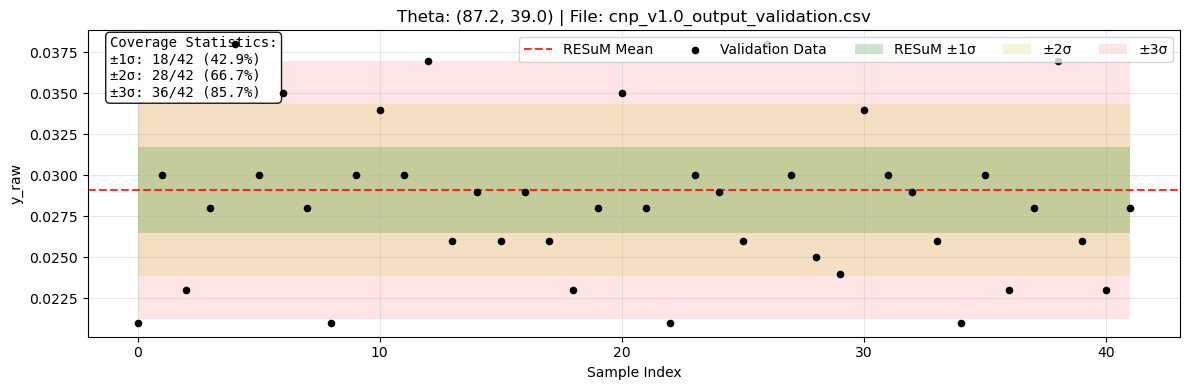

    Coverage statistics for Theta (87.2, 39.0):
    ±1σ: 18/42 (42.9%)
    ±2σ: 28/42 (66.7%)
    ±3σ: 36/42 (85.7%)
  Theta: (92.2, 34.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_92.2_34.0.png


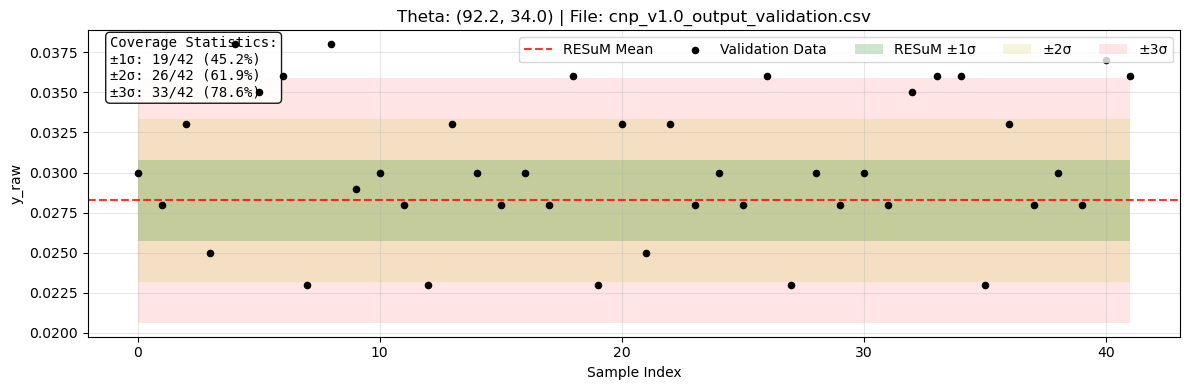

    Coverage statistics for Theta (92.2, 34.0):
    ±1σ: 19/42 (45.2%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 33/42 (78.6%)
  Theta: (101.2, 25.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_101.2_25.0.png


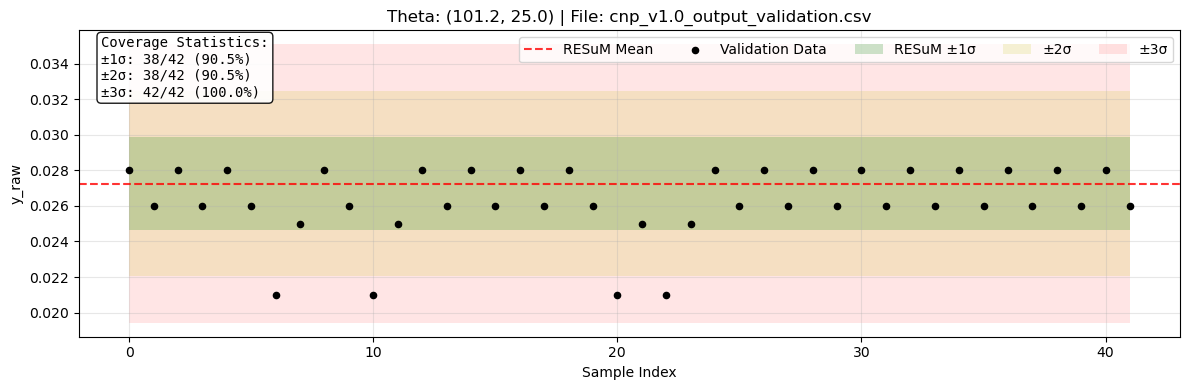

    Coverage statistics for Theta (101.2, 25.0):
    ±1σ: 38/42 (90.5%)
    ±2σ: 38/42 (90.5%)
    ±3σ: 42/42 (100.0%)
  Theta: (95.2, 31.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_95.2_31.0.png


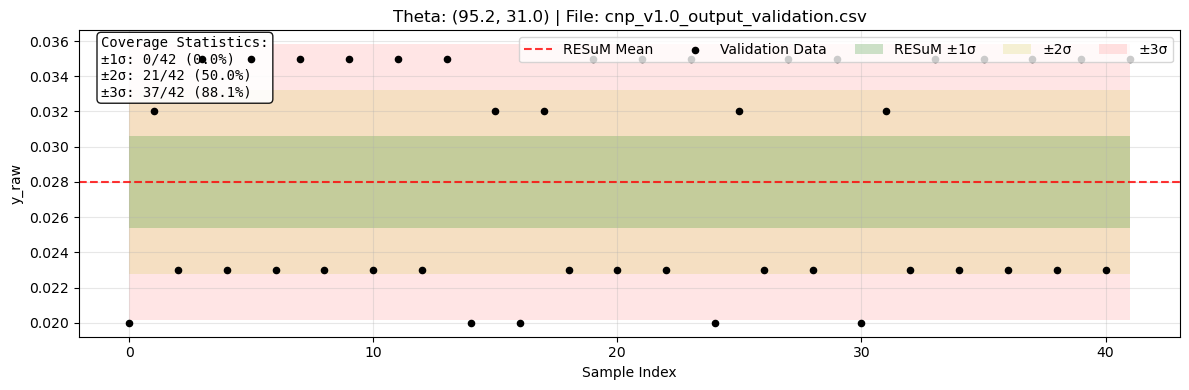

    Coverage statistics for Theta (95.2, 31.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 37/42 (88.1%)
  Theta: (19.2, 107.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_19.2_107.0.png


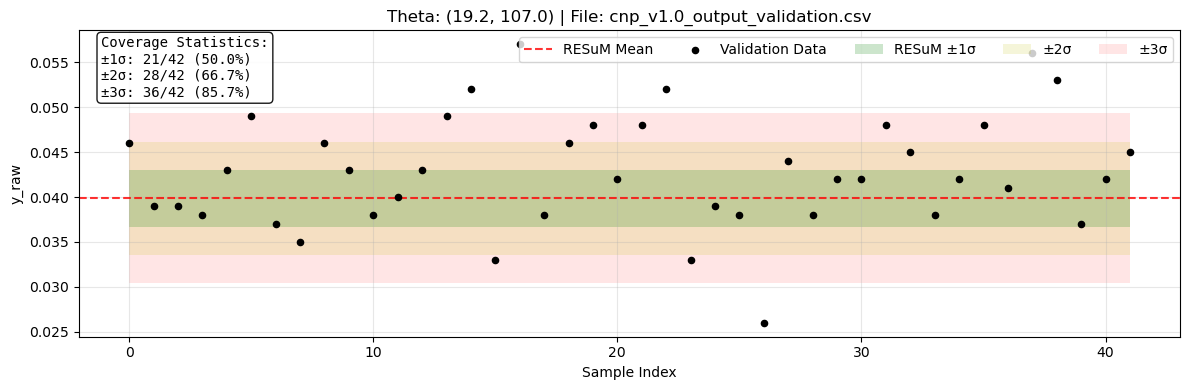

    Coverage statistics for Theta (19.2, 107.0):
    ±1σ: 21/42 (50.0%)
    ±2σ: 28/42 (66.7%)
    ±3σ: 36/42 (85.7%)
  Theta: (39.2, 87.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_39.2_87.0.png


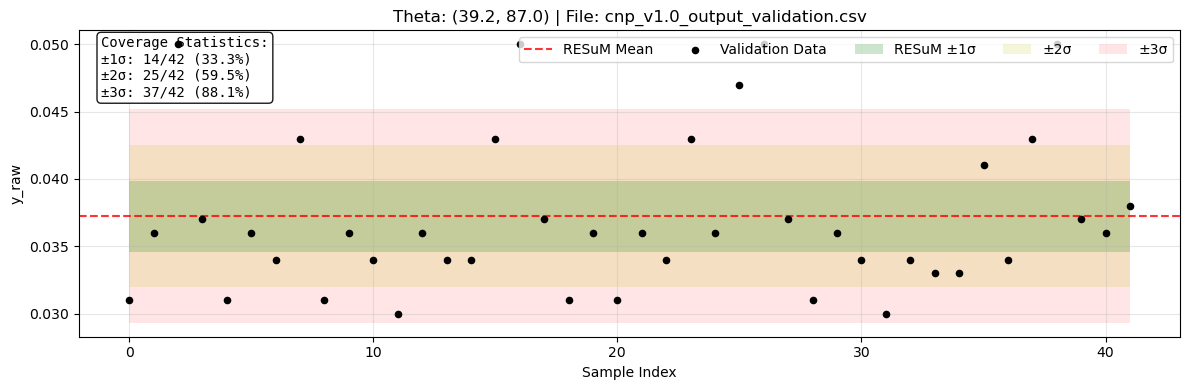

    Coverage statistics for Theta (39.2, 87.0):
    ±1σ: 14/42 (33.3%)
    ±2σ: 25/42 (59.5%)
    ±3σ: 37/42 (88.1%)
  Theta: (25.2, 101.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_25.2_101.0.png


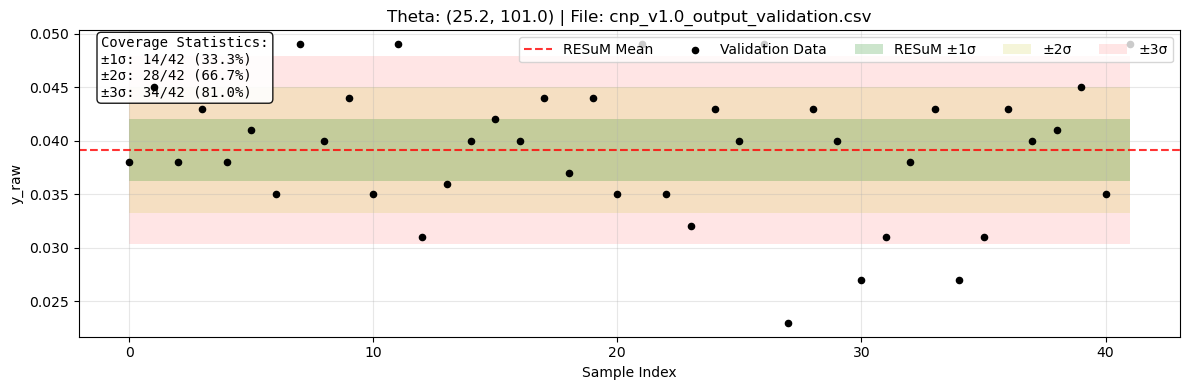

    Coverage statistics for Theta (25.2, 101.0):
    ±1σ: 14/42 (33.3%)
    ±2σ: 28/42 (66.7%)
    ±3σ: 34/42 (81.0%)
  Theta: (114.2, 12.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_114.2_12.0.png


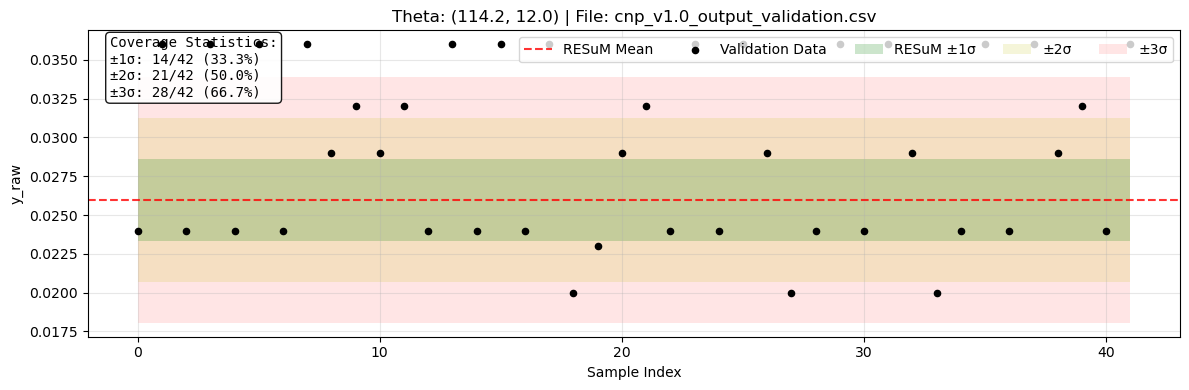

    Coverage statistics for Theta (114.2, 12.0):
    ±1σ: 14/42 (33.3%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 28/42 (66.7%)
  Theta: (59.2, 67.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_59.2_67.0.png


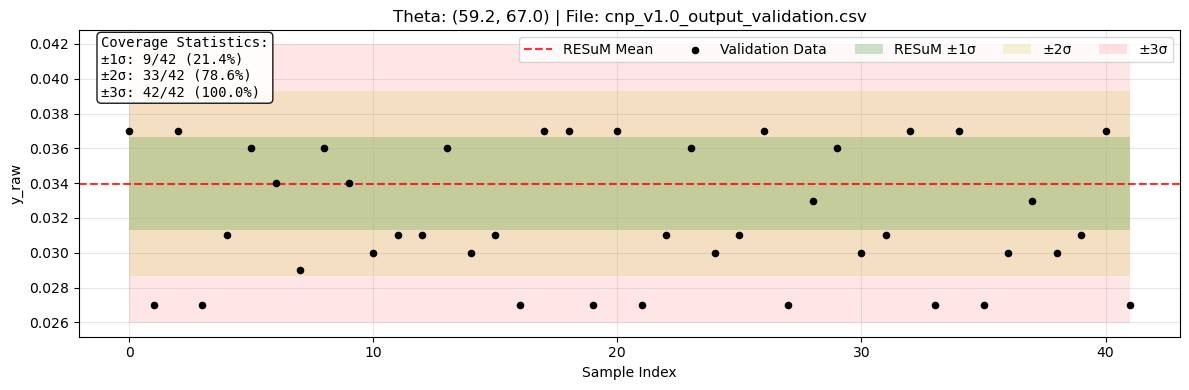

    Coverage statistics for Theta (59.2, 67.0):
    ±1σ: 9/42 (21.4%)
    ±2σ: 33/42 (78.6%)
    ±3σ: 42/42 (100.0%)
  Theta: (54.2, 72.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_54.2_72.0.png


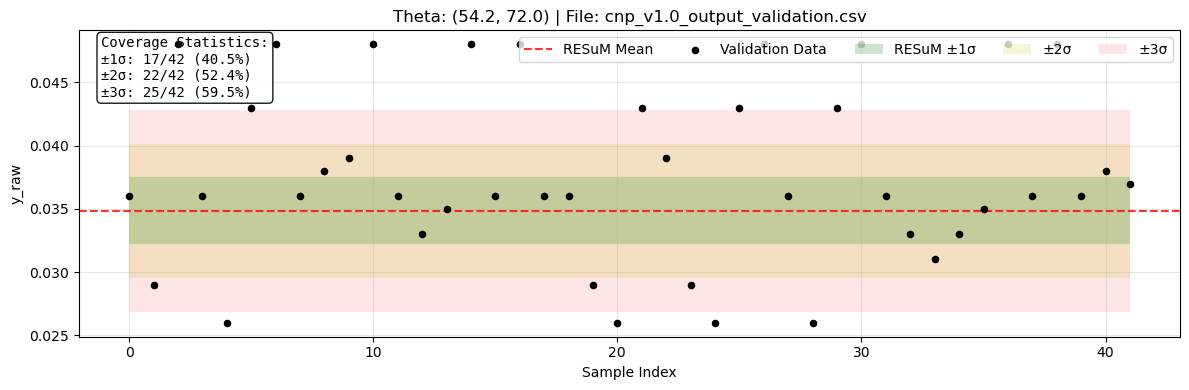

    Coverage statistics for Theta (54.2, 72.0):
    ±1σ: 17/42 (40.5%)
    ±2σ: 22/42 (52.4%)
    ±3σ: 25/42 (59.5%)
  Theta: (51.2, 75.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_51.2_75.0.png


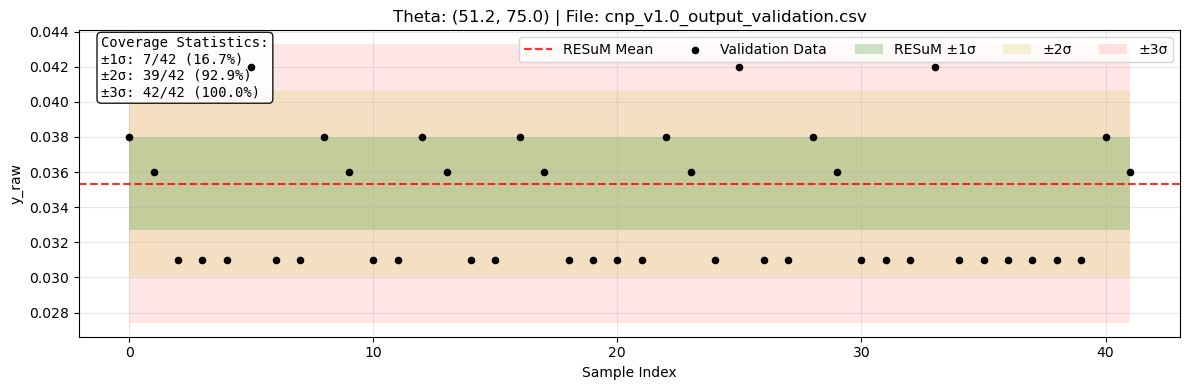

    Coverage statistics for Theta (51.2, 75.0):
    ±1σ: 7/42 (16.7%)
    ±2σ: 39/42 (92.9%)
    ±3σ: 42/42 (100.0%)
  Theta: (30.2, 96.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_30.2_96.0.png


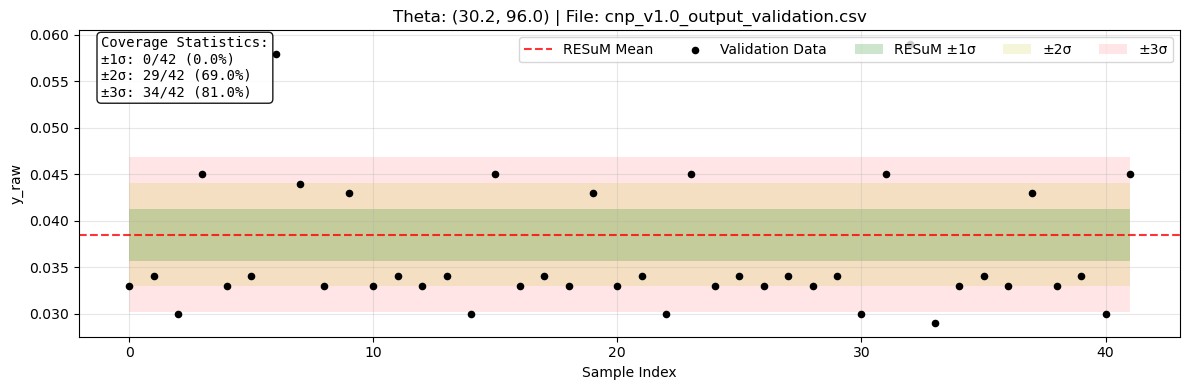

    Coverage statistics for Theta (30.2, 96.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 29/42 (69.0%)
    ±3σ: 34/42 (81.0%)
  Theta: (24.2, 102.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_24.2_102.0.png


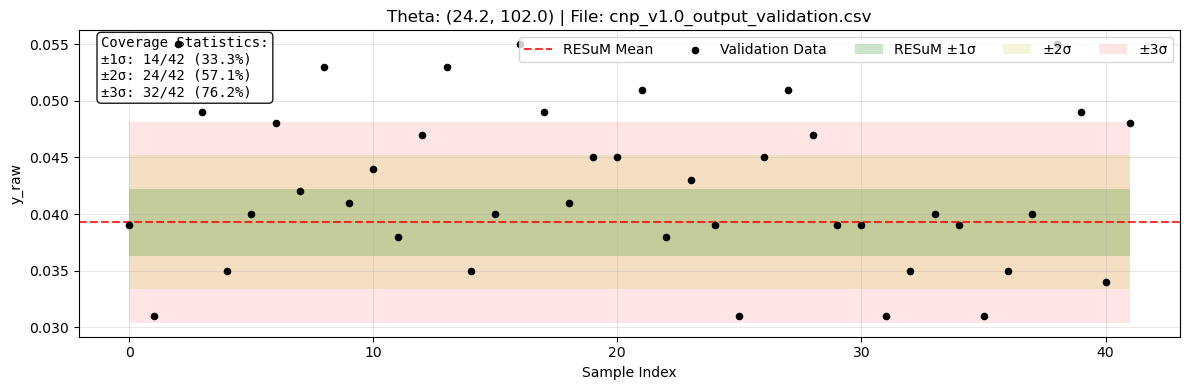

    Coverage statistics for Theta (24.2, 102.0):
    ±1σ: 14/42 (33.3%)
    ±2σ: 24/42 (57.1%)
    ±3σ: 32/42 (76.2%)
  Theta: (37.2, 89.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_37.2_89.0.png


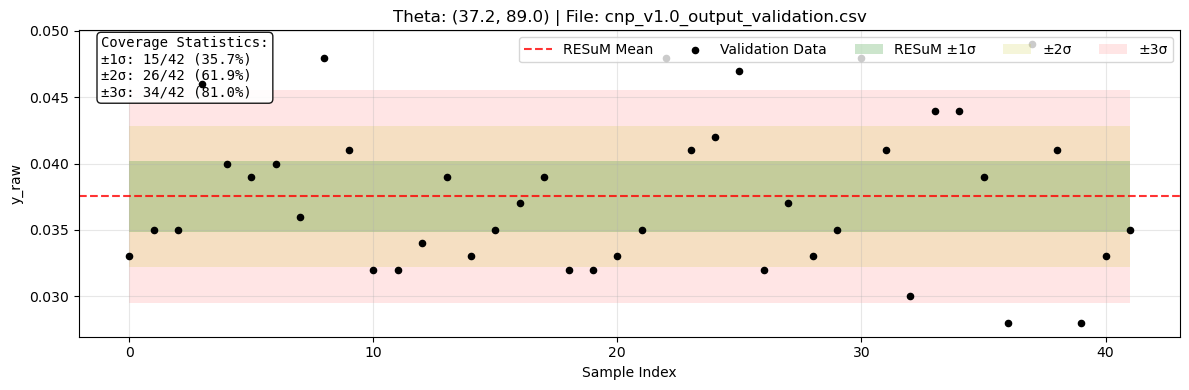

    Coverage statistics for Theta (37.2, 89.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 34/42 (81.0%)
  Theta: (33.2, 93.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_33.2_93.0.png


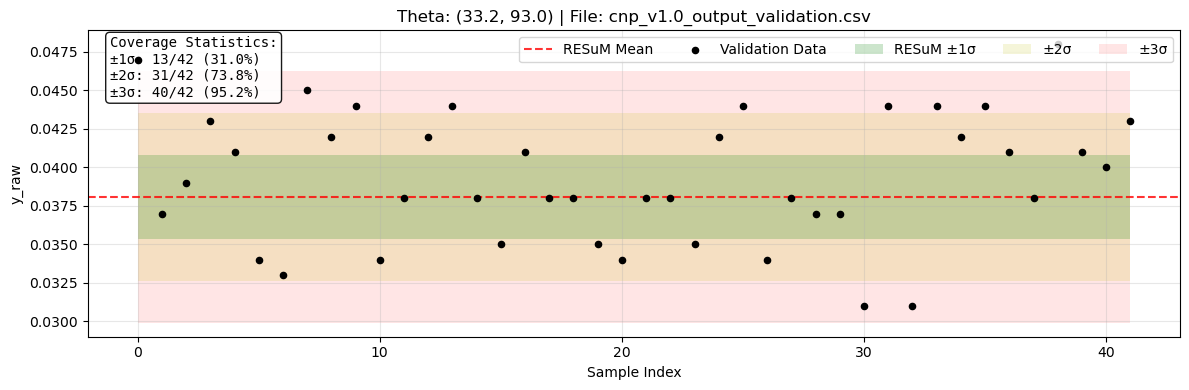

    Coverage statistics for Theta (33.2, 93.0):
    ±1σ: 13/42 (31.0%)
    ±2σ: 31/42 (73.8%)
    ±3σ: 40/42 (95.2%)
  Theta: (74.2, 52.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_74.2_52.0.png


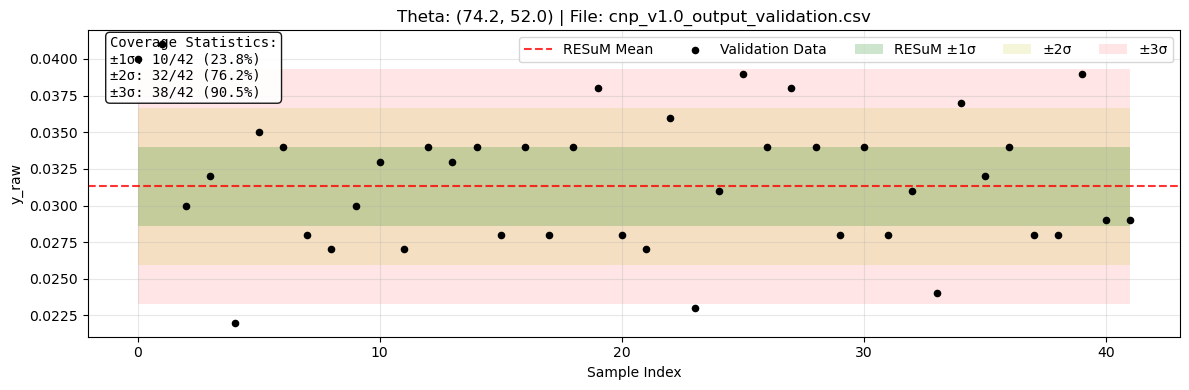

    Coverage statistics for Theta (74.2, 52.0):
    ±1σ: 10/42 (23.8%)
    ±2σ: 32/42 (76.2%)
    ±3σ: 38/42 (90.5%)
  Theta: (88.2, 38.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_88.2_38.0.png


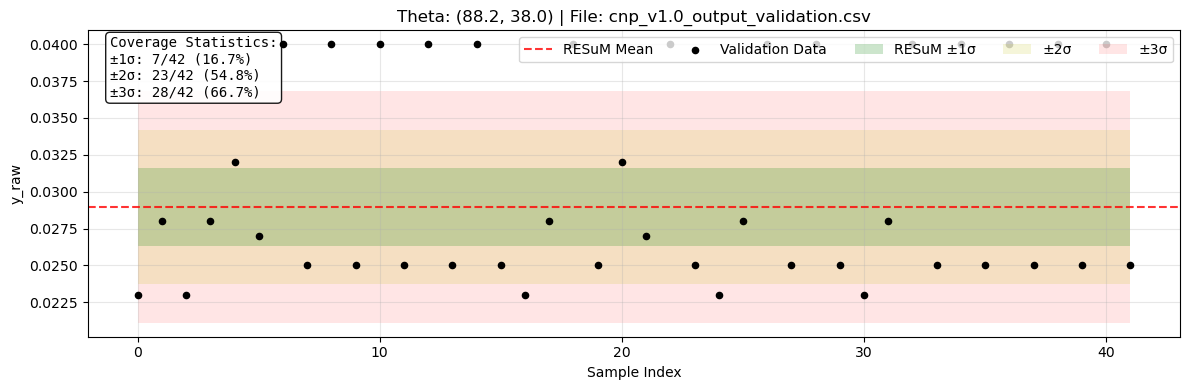

    Coverage statistics for Theta (88.2, 38.0):
    ±1σ: 7/42 (16.7%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 28/42 (66.7%)
  Theta: (72.2, 54.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_72.2_54.0.png


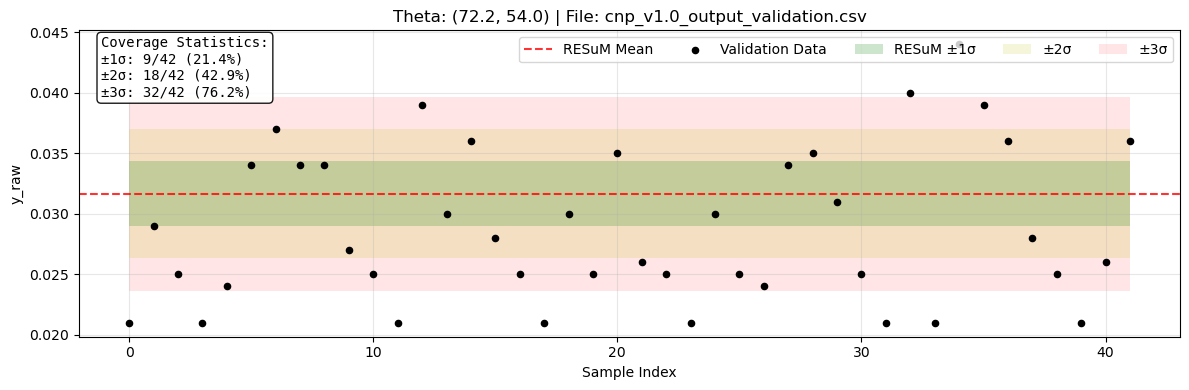

    Coverage statistics for Theta (72.2, 54.0):
    ±1σ: 9/42 (21.4%)
    ±2σ: 18/42 (42.9%)
    ±3σ: 32/42 (76.2%)
  Theta: (115.2, 11.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_115.2_11.0.png


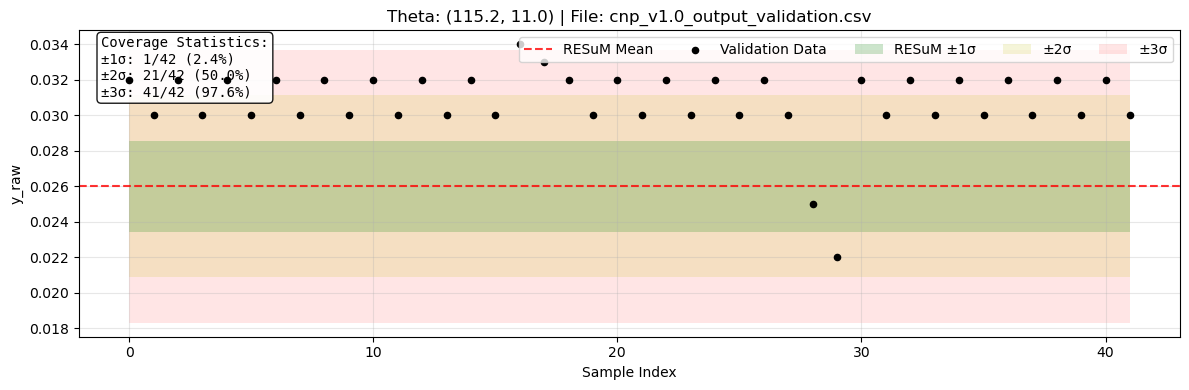

    Coverage statistics for Theta (115.2, 11.0):
    ±1σ: 1/42 (2.4%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 41/42 (97.6%)
  Theta: (111.2, 15.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_111.2_15.0.png


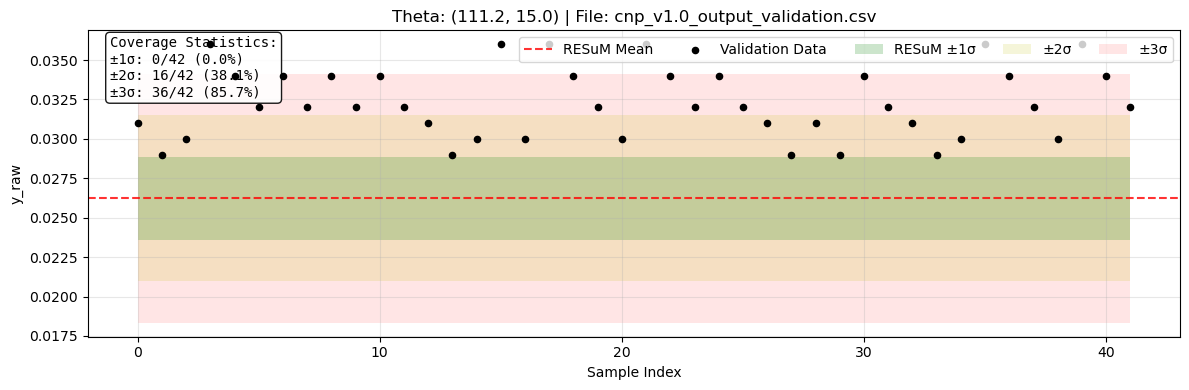

    Coverage statistics for Theta (111.2, 15.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 16/42 (38.1%)
    ±3σ: 36/42 (85.7%)
  Theta: (22.2, 104.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_22.2_104.0.png


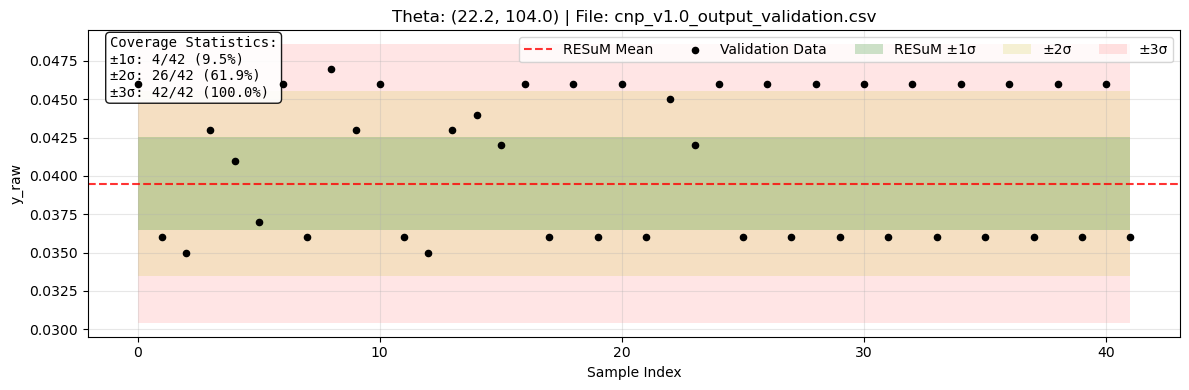

    Coverage statistics for Theta (22.2, 104.0):
    ±1σ: 4/42 (9.5%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 42/42 (100.0%)
  Theta: (55.2, 71.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_55.2_71.0.png


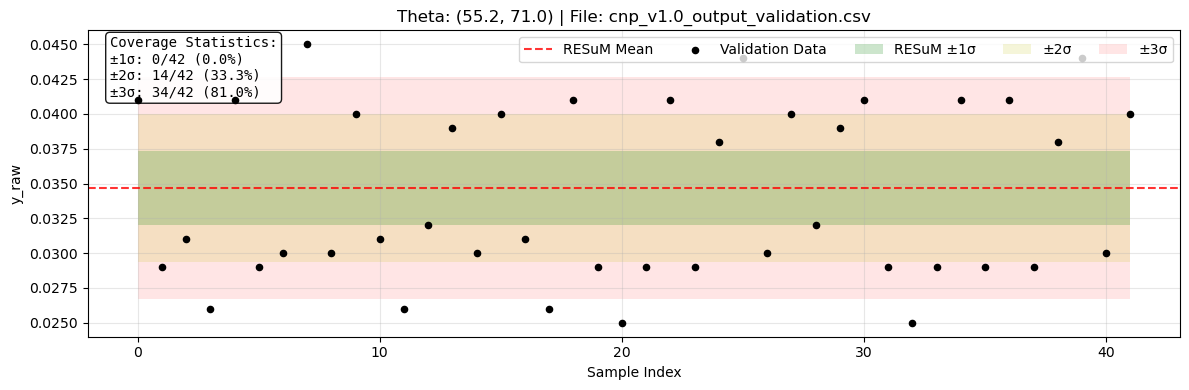

    Coverage statistics for Theta (55.2, 71.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 14/42 (33.3%)
    ±3σ: 34/42 (81.0%)
  Theta: (42.2, 84.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_42.2_84.0.png


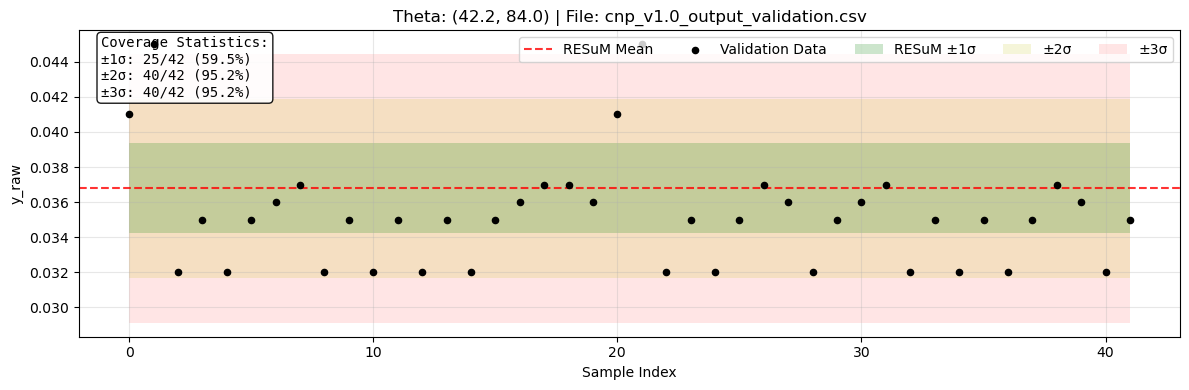

    Coverage statistics for Theta (42.2, 84.0):
    ±1σ: 25/42 (59.5%)
    ±2σ: 40/42 (95.2%)
    ±3σ: 40/42 (95.2%)
  Theta: (21.2, 105.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_21.2_105.0.png


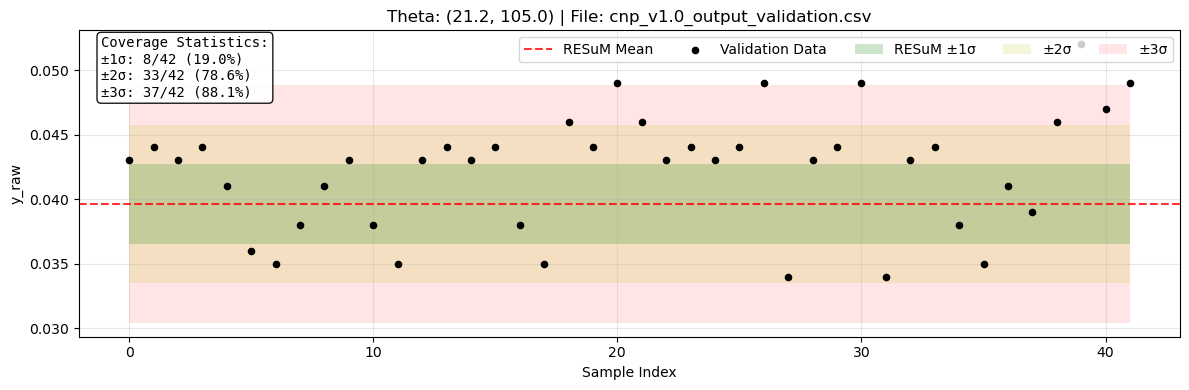

    Coverage statistics for Theta (21.2, 105.0):
    ±1σ: 8/42 (19.0%)
    ±2σ: 33/42 (78.6%)
    ±3σ: 37/42 (88.1%)
  Theta: (78.2, 48.0)
    Saved: ../coherent/out/mfgp/uncertainty_bands_cnp_v1.0_output_validation_theta_78.2_48.0.png


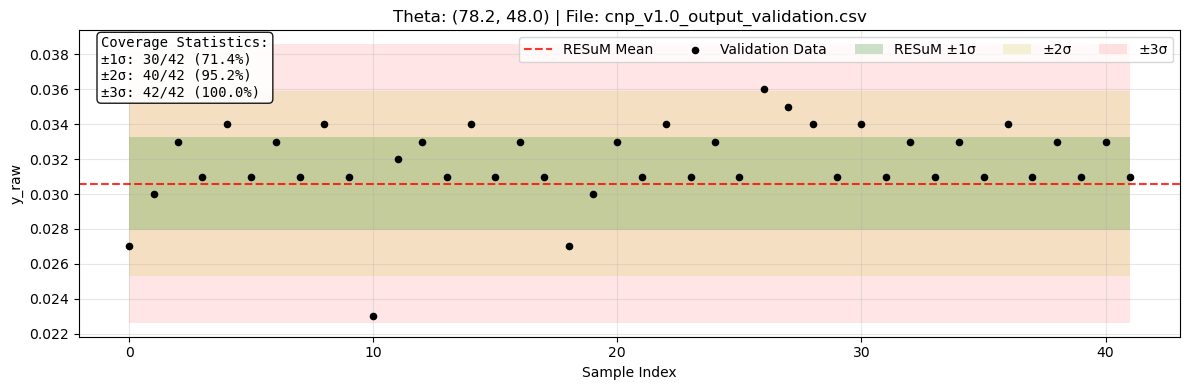

    Coverage statistics for Theta (78.2, 48.0):
    ±1σ: 30/42 (71.4%)
    ±2σ: 40/42 (95.2%)
    ±3σ: 42/42 (100.0%)

5. Creating coverage summary plots...
Coverage summary saved: ../coherent/out/mfgp/coverage_summary.png


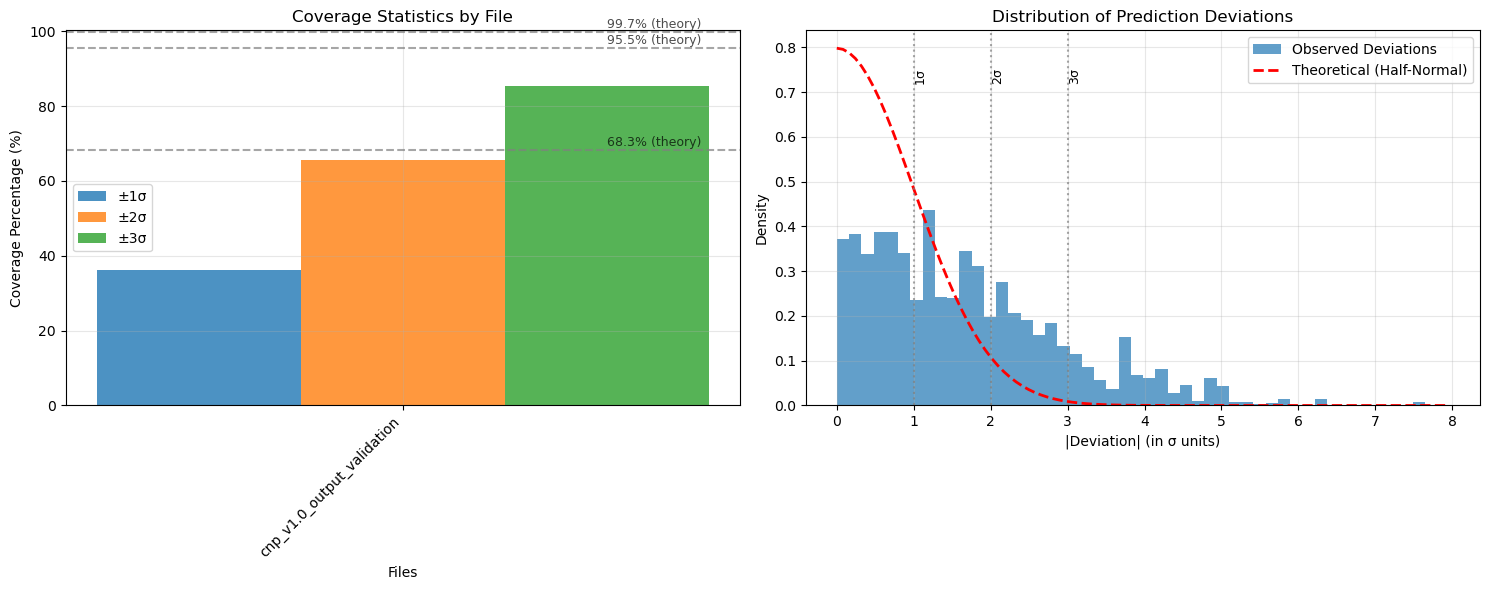


Overall Statistics (1 files, 3696 total points):
±1σ: 1335/3696 (36.1%) | Theoretical: 68.3% | Diff: -32.1%
±2σ: 2419/3696 (65.4%) | Theoretical: 95.5% | Diff: -30.0%
±3σ: 3153/3696 (85.3%) | Theoretical: 99.7% | Diff: -14.4%

6. Creating enhanced contour analysis...
Enhanced contour analysis saved: ../coherent/out/mfgp/enhanced_contour_analysis.png


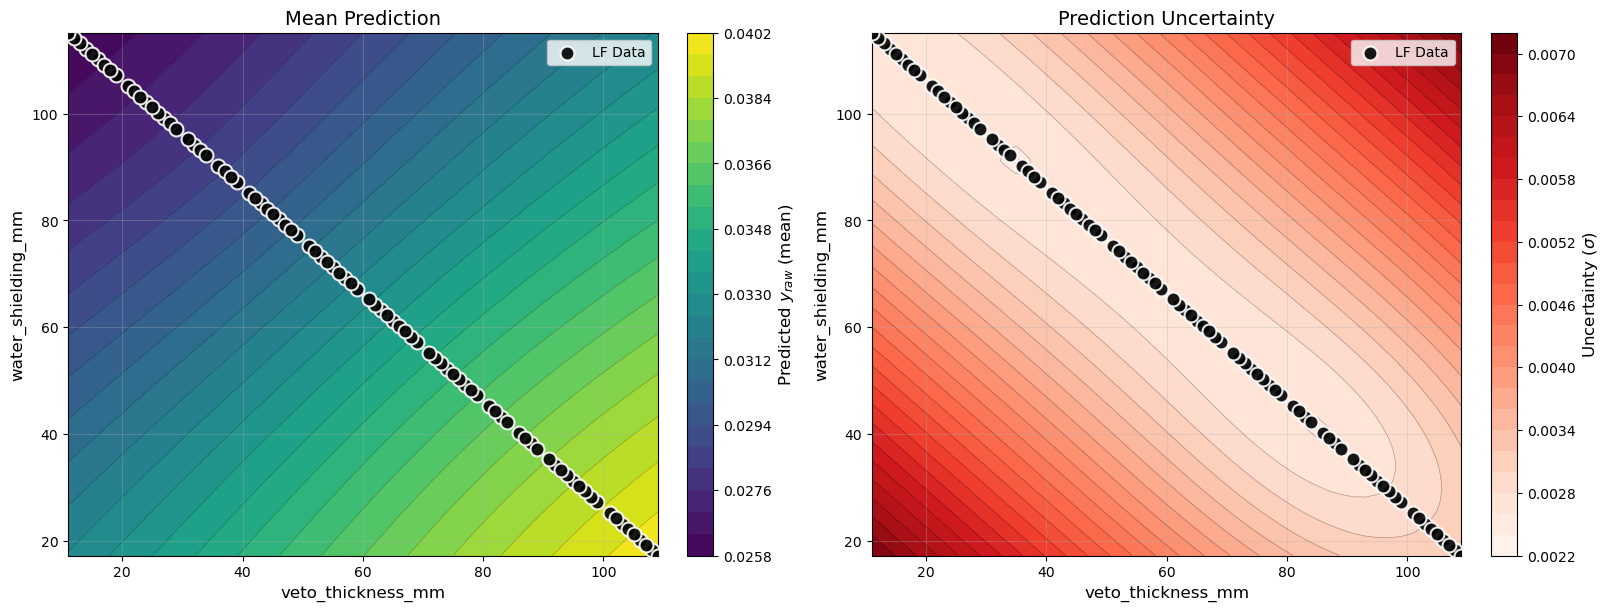


7. Creating prediction vs true value plots...
Prediction vs true (aggregated) plot saved: ../coherent/out/mfgp/predicted_vs_true_cnp_v1.0_output_validation.png


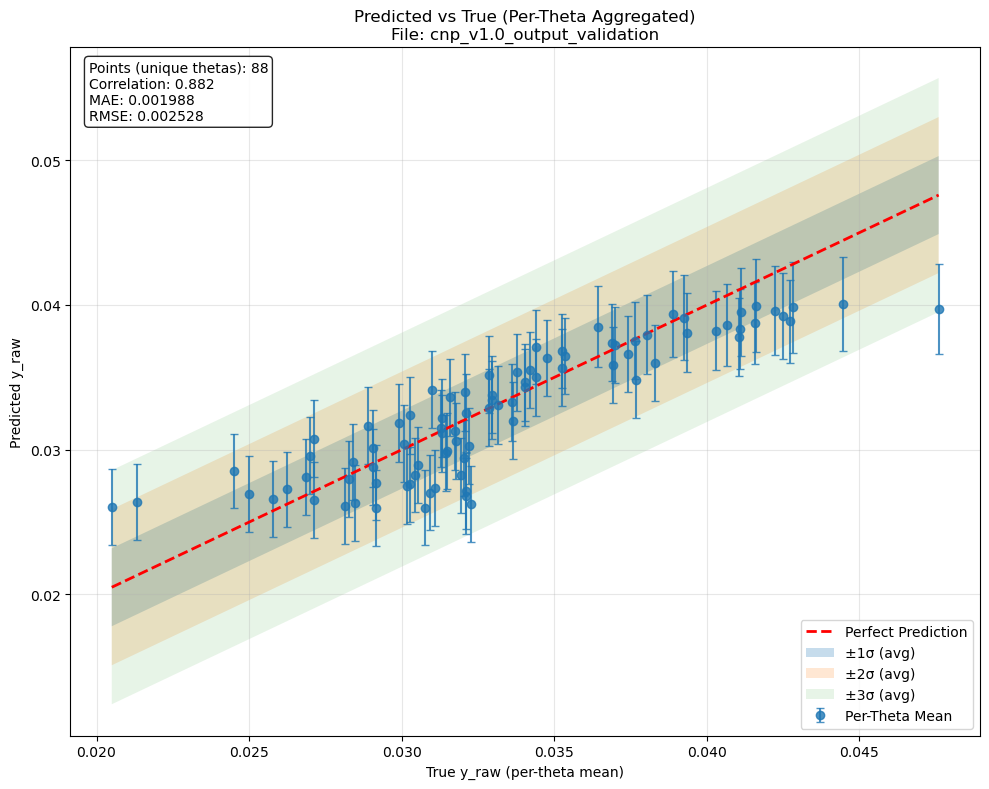


8. Creating plot across all theta values...
    Saved plot: ../coherent/out/mfgp/uncertainty_bands_across_thetas_cnp_v1.0_output_validation.png


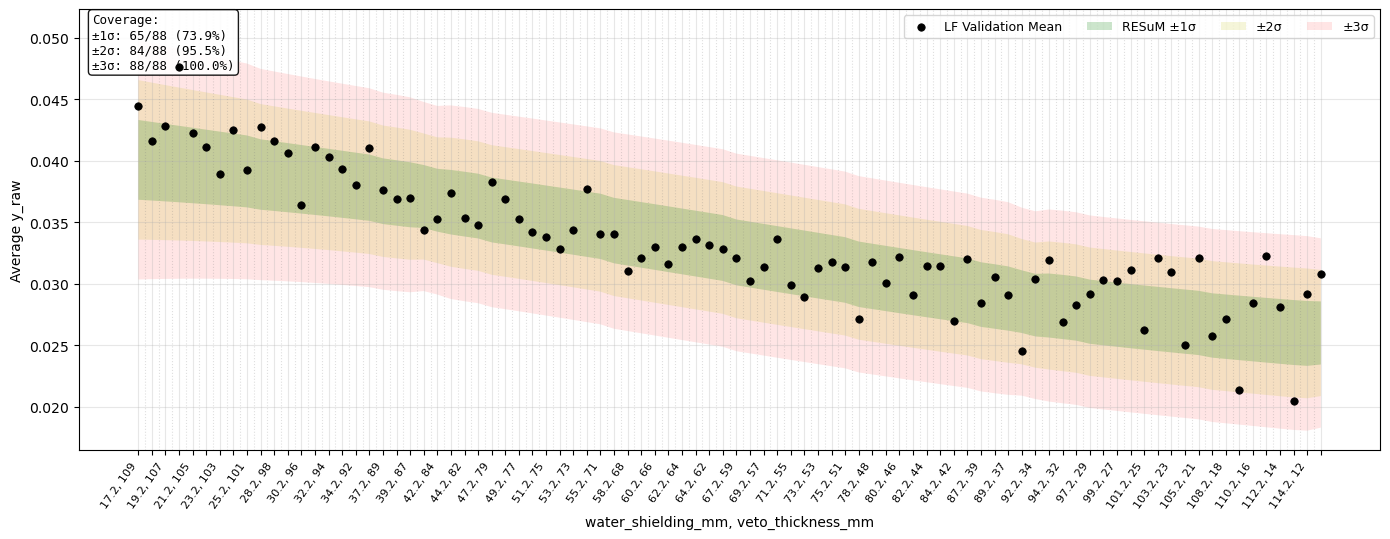


ANALYSIS COMPLETE!
All plots saved to: ../coherent/out/mfgp
🎉 Analysis complete! Check your output folder for all saved plots and results.


In [ ]:
current_file_results = analyzer.run_complete_analysis(
    file_patterns=["../coherent/out/cnp/cnp_v1.0_output_validation.csv"],  # The file we used for training
    fidelity_filter=0.0,     # High fidelity data
    iteration_filter=0,      # First iteration
    plot_individual_groups=True,  # Plot each theta combination
    save_all_plots=True      # 💾 Save ALL generated plots to output folder
)

print("Complete. Check your output folder for all saved plots and results.")